In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import ast

from rnn_utils import *

import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SubsetRandomSampler
from torch.nn import Sigmoid
from sklearn.metrics import precision_recall_curve

from torchmetrics import Accuracy,Recall, Precision, F1Score, AUROC

from sklearn.model_selection import ParameterGrid, ParameterSampler

import numpy as np
import pandas as pd
import json

from tqdm.notebook import tqdm

from config import Settings; settings = Settings()

from ICDMappings import ICDMappings
icdmap = ICDMappings()

import wandb
import torchmetrics.functional as f

idx = pd.IndexSlice

# Reproducibility

In [3]:
# Reproducibility
seed = settings.random_seed

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Create dataset

In [4]:
input = 'history_hot' #one hot encoding of history as opposed to multi-hot
target = 'new_target_hot'

grouping = 'ccs'
ccs_universe = list(icdmap.icd9_3toccs.data.keys())

batch_size=4

Dataset

In [5]:
dataset_folder = '/home/debian/Simao/master-thesis/data/model_ready_dataset/icare2021_diag_A301/dataset_added_new_targets.json'
dataset = ICareDataset(dataset_folder,
                            ccs_universe,
                            grouping,
                          )

processing each patient


  0%|          | 0/262811 [00:00<?, ?it/s]

Dataloaders

In [8]:
train_dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(input,target),
                            sampler=SubsetRandomSampler(dataset.train_indices)
                           )
val_dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(input,target),
                            sampler=SubsetRandomSampler(dataset.val_indices)
                           )
test_dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(input,target),
                            sampler=SubsetRandomSampler(dataset.test_indices)
                           )

# Nº batches
len(train_dataloader)
len(val_dataloader)
len(test_dataloader)

175

38

38

# Small eda

Number of patients in this dataset

In [26]:
len(dataset)

262811

Distribution of sequence length size

In [30]:
lengths = []
for pat in tqdm(dataset):
    lengths.append(pat['length'])
res = pd.Series(lengths)

  0%|          | 0/262811 [00:00<?, ?it/s]

In [41]:
for pat in dataset:
    if pat['length'] == 1:
        print('found new pat')
        pat['history_original']
        pat['target_original']
        print('\n\n')

found new pat


[[663.0, 251.0]]

[[]]




found new pat


[[25.0, 50.0, 99.0]]

[[]]




found new pat


[[120.0, 238.0]]

[[]]




found new pat


[[670.0, 251.0]]

[[]]




found new pat


[[122.0, 159.0]]

[[]]




found new pat


[[134.0, 99.0]]

[[]]




found new pat


[[117.0, 663.0]]

[[]]




found new pat


[[149.0, 149.0]]

[[]]




found new pat


[[258.0, 89.0]]

[[]]




found new pat


[[109.0, 109.0]]

[[]]




found new pat


[[231.0, 234.0]]

[[]]




found new pat


[[259.0, 663.0]]

[[]]




found new pat


[[259.0, 109.0]]

[[]]




found new pat


[[169.0, 169.0]]

[[]]




found new pat


[[258.0, 663.0]]

[[]]




found new pat


[[196.0]]

[[]]




found new pat


[[670.0, 657.0]]

[[]]




found new pat


[[670.0, 259.0]]

[[]]




found new pat


[[238.0, 165.0]]

[[]]




found new pat


[[225.0, 212.0]]

[[]]




found new pat


[[204.0, 91.0]]

[[]]




found new pat


[[198.0, 198.0]]

[[]]




found new pat


[[663.0, 256.0]]

[[]]




found new pat


[[205.0, 205.0, 205.0]]

[[]]




found new pat


[[259.0, 122.0]]

[[]]




found new pat


[[149.0, 200.0]]

[[]]




found new pat


[[211.0, 89.0, 89.0, 89.0]]

[[]]




found new pat


[[232.0, 232.0]]

[[]]




found new pat


[[47.0, 258.0]]

[[]]




found new pat


[[159.0, 159.0]]

[[]]




found new pat


[[48.0, 259.0]]

[[]]




found new pat


[[126.0, 126.0]]

[[]]




found new pat


[[165.0, 205.0, 211.0]]

[[]]




found new pat


[[229.0, 230.0]]

[[]]




found new pat


[[259.0, 257.0]]

[[]]




found new pat


[[144.0, 118.0]]

[[]]




found new pat


[[225.0, 225.0]]

[[]]




found new pat


[[46.0, 46.0, 46.0, 175.0]]

[[]]




found new pat


[[258.0, 258.0]]

[[]]




found new pat


[[258.0, 258.0]]

[[]]




found new pat


[[211.0, 211.0]]

[[]]




found new pat


[[164.0, 663.0]]

[[]]




found new pat


[[8.0, 47.0]]

[[]]




found new pat


[[89.0, 89.0]]

[[]]




found new pat


[[126.0, 238.0]]

[[]]




found new pat


[[108.0, 158.0, 130.0, 253.0, 237.0]]

[[]]




found new pat


[[663.0]]

[[]]




found new pat


[[195.0, 195.0]]

[[]]




found new pat


[[251.0, 238.0]]

[[]]




found new pat


[[117.0, 91.0, 47.0]]

[[]]




found new pat


[[248.0, 115.0, 115.0]]

[[]]




found new pat


[[258.0, 258.0]]

[[]]




found new pat


[[258.0, 173.0]]

[[]]




found new pat


[[247.0, 653.0, 99.0, 29.0, 50.0]]

[[]]




found new pat


[[209.0, 211.0]]

[[]]




found new pat


[[47.0, 258.0, 663.0]]

[[]]




found new pat


[[116.0, 116.0]]

[[]]




found new pat


[[134.0, 253.0]]

[[]]




found new pat


[[238.0]]

[[]]




found new pat


[[195.0, 183.0]]

[[]]




found new pat


[[258.0, 258.0]]

[[]]




found new pat


[[46.0, 46.0]]

[[]]




found new pat


[[258.0, 663.0]]

[[]]




found new pat


[[259.0, 653.0]]

[[]]




found new pat


[[128.0, 125.0]]

[[]]




found new pat


[[253.0, 253.0, 253.0]]

[[]]




found new pat


[[166.0, 120.0]]

[[]]




found new pat


[[200.0, 200.0]]

[[]]




found new pat


[[126.0, 124.0]]

[[]]




found new pat


[[225.0, 225.0]]

[[]]




found new pat


[[94.0, 94.0]]

[[]]




found new pat


[[238.0, 14.0]]

[[]]




found new pat


[[168.0, 168.0]]

[[]]




found new pat


[[253.0, 126.0]]

[[]]




found new pat


[[59.0, 99.0]]

[[]]




found new pat


[[130.0, 258.0]]

[[]]




found new pat


[[195.0, 188.0]]

[[]]




found new pat


[[200.0, 197.0]]

[[]]




found new pat


[[175.0, 175.0]]

[[]]




found new pat


[[663.0, 170.0]]

[[]]




found new pat


[[258.0, 259.0]]

[[]]




found new pat


[[244.0, 244.0, 244.0]]

[[]]




found new pat


[[2.0, 159.0, 653.0]]

[[]]




found new pat


[[204.0, 225.0]]

[[]]




found new pat


[[663.0, 670.0]]

[[]]




found new pat


[[188.0, 195.0]]

[[]]




found new pat


[[94.0, 126.0]]

[[]]




found new pat


[[258.0, 258.0]]

[[]]




found new pat


[[92.0, 211.0]]

[[]]




found new pat


[[663.0, 258.0]]

[[]]




found new pat


[[167.0, 217.0]]

[[]]




found new pat


[[239.0, 232.0]]

[[]]




found new pat


[[58.0, 134.0]]

[[]]




found new pat


[[58.0, 99.0, 237.0]]

[[]]




found new pat


[[258.0, 258.0]]

[[]]




found new pat


[[169.0, 169.0, 169.0]]

[[]]




found new pat


[[126.0, 259.0]]

[[]]




found new pat


[[259.0, 94.0]]

[[]]




found new pat


[[211.0, 225.0]]

[[]]




found new pat


[[166.0, 159.0]]

[[]]




found new pat


[[195.0, 195.0]]

[[]]




found new pat


[[169.0, 46.0]]

[[]]




found new pat


[[232.0, 232.0]]

[[]]




found new pat


[[205.0, 232.0]]

[[]]




found new pat


[[670.0, 670.0]]

[[]]




found new pat


[[47.0, 164.0, 663.0]]

[[]]




found new pat


[[126.0, 126.0]]

[[]]




found new pat


[[238.0, 141.0]]

[[]]




found new pat


[[134.0, 38.0, 130.0]]

[[]]




found new pat


[[249.0, 99.0, 58.0]]

[[]]




found new pat


[[101.0, 50.0, 99.0, 58.0, 58.0]]

[[]]




found new pat


[[126.0, 126.0]]

[[]]




found new pat


[[90.0, 90.0]]

[[]]




found new pat


[[253.0, 128.0]]

[[]]




found new pat


[[232.0, 232.0]]

[[]]




found new pat


[[251.0, 205.0]]

[[]]




found new pat


[[149.0, 197.0]]

[[]]




found new pat


[[99.0, 61.0, 94.0]]

[[]]




found new pat


[[663.0, 119.0]]

[[]]




found new pat


[[229.0, 229.0]]

[[]]




found new pat


[[238.0, 20.0]]

[[]]




found new pat


[[195.0, 195.0, 195.0, 195.0]]

[[]]




found new pat


[[244.0, 239.0]]

[[]]




found new pat


[[47.0, 200.0]]

[[]]




found new pat


[[238.0, 238.0]]

[[]]




found new pat


[[99.0, 107.0, 108.0, 130.0, 58.0]]

[[]]




found new pat


[[4.0, 200.0]]

[[]]




found new pat


[[91.0, 91.0]]

[[]]




found new pat


[[58.0, 58.0]]

[[]]




found new pat


[[259.0, 237.0]]

[[]]




found new pat


[[50.0, 653.0]]

[[]]




found new pat


[[195.0, 191.0, 195.0]]

[[]]




found new pat


[[188.0, 188.0]]

[[]]




found new pat


[[195.0, 195.0, 195.0, 195.0]]

[[]]




found new pat


[[258.0, 670.0]]

[[]]




found new pat


[[195.0, 195.0, 195.0]]

[[]]




found new pat


[[195.0, 188.0]]

[[]]




found new pat


[[50.0, 89.0]]

[[]]




found new pat


[[217.0, 258.0]]

[[]]




found new pat


[[58.0, 152.0]]

[[]]




found new pat


[[198.0, 47.0]]

[[]]




found new pat


[[143.0, 143.0]]

[[]]




found new pat


[[96.0, 58.0, 99.0]]

[[]]




found new pat


[[239.0, 239.0]]

[[]]




found new pat


[[48.0, 48.0]]

[[]]




found new pat


[[108.0, 111.0, 158.0, 59.0]]

[[]]




found new pat


[[196.0, 196.0]]

[[]]




found new pat


[[89.0, 89.0]]

[[]]




found new pat


[[196.0, 195.0, 188.0]]

[[]]




found new pat


[[134.0, 126.0]]

[[]]




found new pat


[[7.0, 147.0]]

[[]]




found new pat


[[659.0, 95.0]]

[[]]




found new pat


[[47.0, 663.0, 258.0]]

[[]]




found new pat


[[232.0, 225.0]]

[[]]




found new pat


[[237.0, 259.0]]

[[]]




found new pat


[[196.0, 258.0]]

[[]]




found new pat


[[211.0, 204.0]]

[[]]




found new pat


[[198.0, 50.0]]

[[]]




found new pat


[[126.0, 126.0]]

[[]]




found new pat


[[181.0, 48.0]]

[[]]




found new pat


[[239.0, 239.0]]

[[]]




found new pat


[[176.0, 167.0]]

[[]]




found new pat


[[196.0, 258.0]]

[[]]




found new pat


[[170.0, 258.0]]

[[]]




found new pat


[[225.0, 225.0]]

[[]]




found new pat


[[205.0, 211.0]]

[[]]




found new pat


[[203.0, 205.0]]

[[]]




found new pat


[[88.0, 89.0, 89.0]]

[[]]




found new pat


[[211.0, 211.0]]

[[]]




found new pat


[[258.0, 258.0]]

[[]]




found new pat


[[134.0, 86.0]]

[[]]




found new pat


[[663.0, 59.0, 247.0, 38.0, 18.0]]

[[]]




found new pat


[[258.0, 258.0]]

[[]]




found new pat


[[167.0, 167.0]]

[[]]




found new pat


[[99.0, 58.0, 96.0]]

[[]]




found new pat


[[195.0, 195.0, 188.0]]

[[]]




found new pat


[[234.0, 234.0]]

[[]]




found new pat


[[670.0, 195.0]]

[[]]




found new pat


[[663.0, 244.0]]

[[]]




found new pat


[[237.0, 101.0, 259.0]]

[[]]




found new pat


[[4.0, 4.0, 4.0]]

[[]]




found new pat


[[119.0, 119.0]]

[[]]




found new pat


[[225.0, 211.0]]

[[]]




found new pat


[[117.0, 200.0]]

[[]]




found new pat


[[197.0, 663.0]]

[[]]




found new pat


[[258.0, 258.0, 10.0]]

[[]]




found new pat


[[42.0, 42.0, 42.0, 109.0]]

[[]]




found new pat


[[258.0, 258.0]]

[[]]




found new pat


[[47.0, 175.0]]

[[]]




found new pat


[[48.0, 655.0]]

[[]]




found new pat


[[185.0, 196.0]]

[[]]




found new pat


[[258.0, 47.0, 670.0]]

[[]]




found new pat


[[126.0, 259.0]]

[[]]




found new pat


[[169.0, 169.0, 169.0]]

[[]]




found new pat


[[95.0, 208.0]]

[[]]




found new pat


[[663.0, 211.0]]

[[]]




found new pat


[[99.0, 91.0]]

[[]]




found new pat


[[259.0, 122.0]]

[[]]




found new pat


[[47.0, 258.0]]

[[]]




found new pat


[[117.0, 200.0]]

[[]]




found new pat


[[95.0, 205.0]]

[[]]




found new pat


[[259.0, 657.0]]

[[]]




found new pat


[[107.0, 96.0]]

[[]]




found new pat


[[200.0, 253.0]]

[[]]




found new pat


[[181.0, 181.0]]

[[]]




found new pat


[[191.0, 191.0, 195.0]]

[[]]




found new pat


[[24.0, 95.0, 58.0, 42.0]]

[[]]




found new pat


[[163.0, 160.0]]

[[]]




found new pat


[[169.0, 169.0]]

[[]]




found new pat


[[47.0, 200.0]]

[[]]




found new pat


[[225.0, 225.0]]

[[]]




found new pat


[[200.0, 253.0]]

[[]]




found new pat


[[134.0, 259.0, 100.0]]

[[]]




found new pat


[[158.0, 108.0]]

[[]]




found new pat


[[126.0, 124.0]]

[[]]




found new pat


[[238.0, 250.0]]

[[]]




found new pat


[[258.0, 663.0]]

[[]]




found new pat


[[239.0, 229.0]]

[[]]




found new pat


[[175.0, 159.0]]

[[]]




found new pat


[[250.0, 251.0]]

[[]]




found new pat


[[663.0, 58.0]]

[[]]




found new pat


[[144.0, 211.0]]

[[]]




found new pat


[[58.0, 99.0]]

[[]]




found new pat


[[663.0]]

[[]]




found new pat


[[134.0, 211.0]]

[[]]




found new pat


[[259.0, 670.0]]

[[]]




found new pat


[[225.0, 203.0]]

[[]]




found new pat


[[126.0, 90.0]]

[[]]




found new pat


[[238.0, 4.0]]

[[]]




found new pat


[[663.0, 47.0, 258.0]]

[[]]




found new pat


[[238.0, 126.0]]

[[]]




found new pat


[[101.0, 237.0]]

[[]]




found new pat


[[204.0, 121.0, 211.0]]

[[]]




found new pat


[[257.0, 105.0]]

[[]]




found new pat


[[226.0, 226.0]]

[[]]




found new pat


[[99.0, 58.0, 101.0]]

[[]]




found new pat


[[165.0, 205.0]]

[[]]




found new pat


[[145.0, 145.0]]

[[]]




found new pat


[[89.0, 86.0]]

[[]]




found new pat


[[47.0, 47.0]]

[[]]




found new pat


[[244.0, 663.0]]

[[]]




found new pat


[[211.0, 211.0]]

[[]]




found new pat


[[232.0, 232.0]]

[[]]




found new pat


[[259.0, 663.0]]

[[]]




found new pat


[[176.0, 258.0]]

[[]]




found new pat


[[91.0, 239.0]]

[[]]




found new pat


[[663.0, 164.0]]

[[]]




found new pat


[[47.0, 663.0]]

[[]]




found new pat


[[126.0, 91.0]]

[[]]




found new pat


[[96.0, 95.0]]

[[]]




found new pat


[[256.0, 258.0, 258.0, 258.0, 661.0]]

[[]]




found new pat


[[214.0, 108.0, 108.0]]

[[]]




found new pat


[[117.0, 47.0]]

[[]]




found new pat


[[258.0, 47.0]]

[[]]




found new pat


[[259.0, 211.0]]

[[]]




found new pat


[[175.0, 258.0]]

[[]]




found new pat


[[200.0, 4.0]]

[[]]




found new pat


[[91.0, 91.0]]

[[]]




found new pat


[[58.0, 200.0]]

[[]]




found new pat


[[670.0, 99.0]]

[[]]




found new pat


[[134.0, 253.0]]

[[]]




found new pat


[[259.0, 198.0]]

[[]]




found new pat


[[655.0, 657.0]]

[[]]




found new pat


[[232.0, 205.0]]

[[]]




found new pat


[[200.0, 232.0]]

[[]]




found new pat


[[95.0, 663.0]]

[[]]




found new pat


[[109.0, 109.0]]

[[]]




found new pat


[[122.0]]

[[]]




found new pat


[[134.0, 259.0]]

[[]]




found new pat


[[168.0, 168.0]]

[[]]




found new pat


[[52.0, 62.0]]

[[]]




found new pat


[[258.0, 249.0]]

[[]]




found new pat


[[107.0, 99.0]]

[[]]




found new pat


[[229.0, 204.0]]

[[]]




found new pat


[[136.0, 136.0]]

[[]]




found new pat


[[239.0, 239.0]]

[[]]




found new pat


[[657.0, 259.0]]

[[]]




found new pat


[[258.0, 258.0]]

[[]]




found new pat


[[164.0, 166.0]]

[[]]




found new pat


[[48.0, 670.0, 188.0, 195.0]]

[[]]




found new pat


[[211.0, 211.0]]

[[]]




found new pat


[[205.0, 205.0]]

[[]]




found new pat


[[259.0, 175.0, 164.0]]

[[]]




found new pat


[[663.0, 258.0, 258.0, 258.0]]

[[]]




found new pat


[[119.0, 134.0, 253.0, 126.0]]

[[]]




found new pat


[[134.0, 134.0]]

[[]]




found new pat


[[91.0, 91.0]]

[[]]




found new pat


[[163.0, 163.0, 28.0]]

[[]]




found new pat


[[200.0, 200.0]]

[[]]




found new pat


[[159.0, 122.0]]

[[]]




found new pat


[[200.0, 4.0]]

[[]]




found new pat


[[175.0, 175.0]]

[[]]




found new pat


[[143.0, 143.0]]

[[]]




found new pat


[[158.0, 238.0, 653.0, 157.0]]

[[]]




found new pat


[[670.0, 259.0]]

[[]]




found new pat


[[258.0, 258.0]]

[[]]




found new pat


[[225.0, 230.0]]

[[]]




found new pat


[[195.0, 195.0]]

[[]]




found new pat


[[225.0, 232.0]]

[[]]




found new pat


[[128.0, 126.0]]

[[]]




found new pat


[[94.0, 92.0]]

[[]]




found new pat


[[259.0, 259.0]]

[[]]




found new pat


[[94.0, 232.0]]

[[]]




found new pat


[[205.0, 89.0]]

[[]]




found new pat


[[122.0, 195.0, 195.0, 195.0]]

[[]]




found new pat


[[96.0, 200.0]]

[[]]




found new pat


[[663.0, 225.0]]

[[]]




found new pat


[[655.0, 197.0]]

[[]]




found new pat


[[258.0, 176.0]]

[[]]




found new pat


[[117.0, 663.0, 663.0]]

[[]]




found new pat


[[203.0, 211.0, 99.0, 115.0]]

[[]]




found new pat


[[44.0, 259.0]]

[[]]




found new pat


[[196.0]]

[[]]




found new pat


[[195.0, 195.0]]

[[]]




found new pat


[[92.0, 244.0]]

[[]]




found new pat


[[89.0, 663.0]]

[[]]




found new pat


[[253.0, 663.0]]

[[]]




found new pat


[[58.0, 259.0]]

[[]]




found new pat


[[7.0, 108.0]]

[[]]




found new pat


[[120.0, 238.0]]

[[]]




found new pat


[[250.0, 670.0]]

[[]]




found new pat


[[164.0, 663.0]]

[[]]




found new pat


[[47.0, 118.0]]

[[]]




found new pat


[[91.0, 253.0]]

[[]]




found new pat


[[152.0, 152.0]]

[[]]




found new pat


[[670.0, 196.0]]

[[]]




found new pat


[[90.0, 91.0]]

[[]]




found new pat


[[253.0, 125.0]]

[[]]




found new pat


[[153.0, 107.0]]

[[]]




found new pat


[[203.0, 225.0]]

[[]]




found new pat


[[239.0, 239.0]]

[[]]




found new pat


[[239.0, 239.0, 232.0]]

[[]]




found new pat


[[198.0, 663.0]]

[[]]




found new pat


[[134.0, 101.0]]

[[]]




found new pat


[[96.0, 99.0]]

[[]]




found new pat


[[250.0, 250.0]]

[[]]




found new pat


[[670.0, 48.0]]

[[]]




found new pat


[[99.0, 50.0, 58.0, 58.0]]

[[]]




found new pat


[[159.0]]

[[]]




found new pat


[[159.0, 238.0]]

[[]]




found new pat


[[180.0, 180.0]]

[[]]




found new pat


[[95.0, 95.0]]

[[]]




found new pat


[[42.0, 42.0, 20.0]]

[[]]




found new pat


[[653.0, 109.0, 109.0]]

[[]]




found new pat


[[47.0, 663.0]]

[[]]




found new pat


[[226.0, 226.0]]

[[]]




found new pat


[[253.0, 241.0, 158.0, 99.0, 48.0, 58.0, 58.0, 107.0]]

[[]]




found new pat


[[259.0, 205.0]]

[[]]




found new pat


[[239.0, 239.0]]

[[]]




found new pat


[[58.0, 99.0, 50.0]]

[[]]




found new pat


[[670.0, 259.0]]

[[]]




found new pat


[[47.0, 663.0]]

[[]]




found new pat


[[244.0, 244.0]]

[[]]




found new pat


[[124.0, 134.0]]

[[]]




found new pat


[[229.0, 229.0]]

[[]]




found new pat


[[47.0, 198.0]]

[[]]




found new pat


[[90.0, 90.0]]

[[]]




found new pat


[[113.0, 653.0]]

[[]]




found new pat


[[253.0, 244.0]]

[[]]




found new pat


[[48.0, 48.0]]

[[]]




found new pat


[[109.0, 111.0]]

[[]]




found new pat


[[142.0, 142.0]]

[[]]




found new pat


[[99.0, 670.0]]

[[]]




found new pat


[[115.0, 115.0]]

[[]]




found new pat


[[176.0, 168.0]]

[[]]




found new pat


[[663.0, 663.0]]

[[]]




found new pat


[[653.0, 657.0]]

[[]]




found new pat


[[663.0, 164.0, 47.0]]

[[]]




found new pat


[[251.0, 251.0]]

[[]]




found new pat


[[258.0, 258.0]]

[[]]




found new pat


[[249.0, 670.0]]

[[]]




found new pat


[[205.0, 225.0]]

[[]]




found new pat


[[244.0, 119.0, 253.0]]

[[]]




found new pat


[[89.0, 91.0]]

[[]]




found new pat


[[146.0, 155.0, 41.0]]

[[]]




found new pat


[[205.0, 205.0]]

[[]]




found new pat


[[653.0, 99.0, 657.0, 653.0]]

[[]]




found new pat


[[127.0, 122.0]]

[[]]




found new pat


[[128.0, 124.0]]

[[]]




found new pat


[[235.0, 205.0]]

[[]]




found new pat


[[663.0, 244.0]]

[[]]




found new pat


[[155.0, 238.0, 238.0]]

[[]]




found new pat


[[95.0, 203.0]]

[[]]




found new pat


[[259.0, 237.0]]

[[]]




found new pat


[[50.0, 95.0, 99.0, 3.0, 159.0]]

[[]]




found new pat


[[91.0, 91.0]]

[[]]




found new pat


[[205.0, 211.0]]

[[]]




found new pat


[[258.0, 663.0]]

[[]]




found new pat


[[128.0, 253.0]]

[[]]




found new pat


[[204.0, 226.0]]

[[]]




found new pat


[[200.0, 200.0]]

[[]]




found new pat


[[108.0, 122.0]]

[[]]




found new pat


[[122.0]]

[[]]




found new pat


[[47.0, 663.0, 205.0, 258.0]]

[[]]




found new pat


[[117.0, 89.0, 663.0, 258.0]]

[[]]




found new pat


[[239.0, 244.0]]

[[]]




found new pat


[[239.0, 239.0]]

[[]]




found new pat


[[89.0, 89.0]]

[[]]




found new pat


[[84.0, 259.0]]

[[]]




found new pat


[[236.0, 236.0, 236.0]]

[[]]




found new pat


[[238.0, 108.0]]

[[]]




found new pat


[[205.0, 205.0]]

[[]]




found new pat


[[204.0, 48.0]]

[[]]




found new pat


[[259.0, 663.0]]

[[]]




found new pat


[[205.0, 44.0]]

[[]]




found new pat


[[204.0, 119.0]]

[[]]




found new pat


[[259.0, 237.0]]

[[]]




found new pat


[[258.0, 661.0, 258.0]]

[[]]




found new pat


[[50.0, 660.0]]

[[]]




found new pat


[[134.0, 134.0]]

[[]]




found new pat


[[89.0, 211.0]]

[[]]




found new pat


[[44.0, 259.0, 670.0]]

[[]]




found new pat


[[258.0, 196.0]]

[[]]




found new pat


[[176.0, 258.0]]

[[]]




found new pat


[[237.0, 107.0, 122.0, 238.0]]

[[]]




found new pat


[[663.0, 258.0]]

[[]]




found new pat


[[159.0, 168.0]]

[[]]




found new pat


[[258.0, 258.0, 196.0]]

[[]]




found new pat


[[84.0, 109.0]]

[[]]




found new pat


[[90.0, 173.0]]

[[]]




found new pat


[[109.0, 89.0]]

[[]]




found new pat


[[670.0, 249.0]]

[[]]




found new pat


[[195.0, 188.0]]

[[]]




found new pat


[[136.0, 136.0]]

[[]]




found new pat


[[663.0, 47.0, 258.0, 258.0]]

[[]]




found new pat


[[663.0, 47.0]]

[[]]




found new pat


[[205.0, 205.0]]

[[]]




found new pat


[[168.0, 173.0]]

[[]]




found new pat


[[135.0, 124.0]]

[[]]




found new pat


[[169.0, 169.0]]

[[]]




found new pat


[[663.0, 657.0]]

[[]]




found new pat


[[238.0, 259.0]]

[[]]




found new pat


[[197.0, 253.0]]

[[]]




found new pat


[[258.0, 87.0]]

[[]]




found new pat


[[126.0, 253.0]]

[[]]




found new pat


[[46.0, 46.0]]

[[]]




found new pat


[[258.0, 89.0, 663.0]]

[[]]




found new pat


[[211.0, 244.0]]

[[]]




found new pat


[[663.0, 204.0]]

[[]]




found new pat


[[58.0, 259.0, 107.0, 99.0]]

[[]]




found new pat


[[122.0, 122.0]]

[[]]




found new pat


[[91.0, 91.0]]

[[]]




found new pat


[[259.0, 58.0]]

[[]]




found new pat


[[258.0, 663.0]]

[[]]




found new pat


[[196.0, 188.0]]

[[]]




found new pat


[[195.0, 195.0]]

[[]]




found new pat


[[136.0, 94.0]]

[[]]




found new pat


[[232.0, 134.0]]

[[]]




found new pat


[[258.0, 176.0]]

[[]]




found new pat


[[663.0, 4.0]]

[[]]




found new pat


[[258.0, 258.0]]

[[]]




found new pat


[[258.0, 175.0]]

[[]]




found new pat


[[259.0, 89.0]]

[[]]




found new pat


[[109.0]]

[[]]




found new pat


[[165.0, 159.0]]

[[]]




found new pat


[[142.0]]

[[]]




found new pat


[[163.0, 165.0]]

[[]]




found new pat


[[89.0, 89.0]]

[[]]




found new pat


[[190.0, 195.0]]

[[]]




found new pat


[[205.0, 258.0]]

[[]]




found new pat


[[167.0, 259.0]]

[[]]




found new pat


[[116.0, 116.0]]

[[]]




found new pat


[[126.0, 92.0]]

[[]]




found new pat


[[43.0, 42.0]]

[[]]




found new pat


[[128.0, 253.0]]

[[]]




found new pat


[[200.0, 4.0]]

[[]]




found new pat


[[211.0, 211.0]]

[[]]




found new pat


[[204.0, 205.0]]

[[]]




found new pat


[[253.0, 92.0]]

[[]]




found new pat


[[205.0, 258.0]]

[[]]




found new pat


[[239.0, 239.0]]

[[]]




found new pat


[[253.0, 128.0]]

[[]]




found new pat


[[91.0, 91.0]]

[[]]




found new pat


[[134.0, 128.0]]

[[]]




found new pat


[[136.0, 258.0]]

[[]]




found new pat


[[89.0, 89.0]]

[[]]




found new pat


[[122.0, 51.0, 107.0, 99.0, 237.0]]

[[]]




found new pat


[[239.0, 239.0]]

[[]]




found new pat


[[122.0, 107.0, 259.0, 155.0, 237.0, 145.0, 50.0]]

[[]]




found new pat


[[238.0, 59.0]]

[[]]




found new pat


[[161.0, 159.0, 99.0, 44.0]]

[[]]




found new pat


[[99.0, 249.0]]

[[]]




found new pat


[[99.0, 211.0]]

[[]]




found new pat


[[99.0, 111.0]]

[[]]




found new pat


[[225.0, 232.0]]

[[]]




found new pat


[[157.0]]

[[]]




found new pat


[[259.0, 166.0]]

[[]]




found new pat


[[258.0, 663.0]]

[[]]




found new pat


[[225.0, 225.0]]

[[]]




found new pat


[[89.0, 89.0]]

[[]]




found new pat


[[657.0, 657.0]]

[[]]




found new pat


[[235.0, 235.0]]

[[]]




found new pat


[[226.0, 226.0]]

[[]]




found new pat


[[94.0, 87.0]]

[[]]




found new pat


[[195.0, 195.0]]

[[]]




found new pat


[[89.0, 89.0, 91.0, 258.0]]

[[]]




found new pat


[[95.0, 95.0]]

[[]]




found new pat


[[258.0, 663.0]]

[[]]




found new pat


[[86.0, 258.0]]

[[]]




found new pat


[[670.0, 58.0]]

[[]]




found new pat


[[128.0, 253.0]]

[[]]




found new pat


[[195.0, 195.0]]

[[]]




found new pat


[[89.0, 134.0]]

[[]]




found new pat


[[191.0, 670.0, 192.0, 219.0, 192.0, 188.0]]

[[]]




found new pat


[[258.0, 258.0]]

[[]]




found new pat


[[149.0, 653.0, 660.0]]

[[]]




found new pat


[[168.0, 258.0]]

[[]]




found new pat


[[229.0, 229.0]]

[[]]




found new pat


[[204.0, 204.0]]

[[]]




found new pat


[[232.0, 660.0]]

[[]]




found new pat


[[259.0, 111.0]]

[[]]




found new pat


[[244.0, 244.0, 244.0]]

[[]]




found new pat


[[258.0, 175.0]]

[[]]




found new pat


[[94.0, 92.0]]

[[]]




found new pat


[[88.0, 175.0]]

[[]]




found new pat


[[209.0, 205.0]]

[[]]




found new pat


[[124.0, 91.0]]

[[]]




found new pat


[[232.0, 232.0]]

[[]]




found new pat


[[259.0, 237.0]]

[[]]




found new pat


[[259.0, 99.0]]

[[]]




found new pat


[[655.0, 58.0]]

[[]]




found new pat


[[196.0, 196.0]]

[[]]




found new pat


KeyboardInterrupt: 

In [37]:
pat.keys()

dict_keys(['history_original', 'target_original', 'new_target_original', 'history_hot', 'target_hot', 'new_target_hot', 'history_mhot', 'target_mhot', 'new_target_mhot', 'pid', 'length'])

In [38]:
pat['history_original']

[[663.0, 251.0]]

In [39]:
pat['target_original']

[[]]

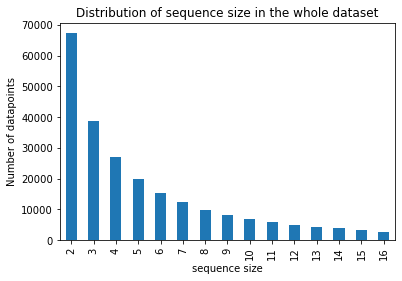

In [55]:
top_15 = pd.concat([res[res!=1].value_counts().rename('Count'),res[res!=1].value_counts(normalize=True).rename('frac').round(2)],axis=1).head(15)
top_15.Count.plot.bar();
plt.title('Distribution of sequence size in the whole dataset');
plt.xlabel('sequence size');
plt.ylabel('Number of datapoints');
plt.savefig('media/dist_seq_size_dataset.png');

distribution of timestep size

In [86]:
%env WANDB_START_METHOD='thread'

Error in callback <function _WandbInit._resume_backend at 0x7f32b2a081f0> (for pre_run_cell):


Exception: The wandb backend process has shutdown

env: WANDB_START_METHOD='thread'
Error in callback <function _WandbInit._pause_backend at 0x7f32b2a09900> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [84]:
del wandb

Error in callback <function _WandbInit._resume_backend at 0x7f32b2a081f0> (for pre_run_cell):


Exception: The wandb backend process has shutdown

NameError: name 'wandb' is not defined

Error in callback <function _WandbInit._pause_backend at 0x7f32b2a09900> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [83]:
for batch in train_dataloader:
    compute_size_batch(batch,how='all')
    compute_positives_batch(batch,how='all')
    break

Error in callback <function _WandbInit._resume_backend at 0x7f32b2a081f0> (for pre_run_cell):


Exception: The wandb backend process has shutdown

15282

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 5., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 2.,
        0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 6., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 2., 0., 

Error in callback <function _WandbInit._pause_backend at 0x7f32b2a09900> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [75]:
compute_prevalence_dataloader(train_dataloader,how='all')

iterating dataloader to compute prevalence


  0%|          | 0/22996 [00:00<?, ?it/s]

tensor([1.7331e-06, 1.1768e-06, 7.7476e-06, 1.1331e-05, 2.7819e-07, 1.1628e-06,
        1.3999e-05, 4.6375e-06, 1.2574e-06, 4.4066e-06, 1.0655e-06, 2.1143e-07,
        1.0766e-06, 4.0477e-06, 1.1990e-06, 8.9021e-07, 1.1295e-06, 1.5106e-06,
        0.0000e+00, 5.8838e-06, 1.0710e-06, 8.7074e-07, 4.4483e-06, 6.8964e-06,
        9.0134e-07, 2.4759e-07, 0.0000e+00, 7.3443e-07, 8.3680e-06, 2.6985e-07,
        9.7367e-08, 2.6289e-06, 0.0000e+00, 4.0866e-06, 1.2491e-06, 5.5193e-06,
        3.2270e-07, 1.8027e-06, 1.0182e-06, 1.9140e-06, 9.3027e-06, 7.8255e-06,
        4.1729e-08, 1.5442e-05, 0.0000e+00, 9.6727e-06, 8.4287e-05, 4.8199e-05,
        0.0000e+00, 2.6153e-05, 9.9036e-06, 1.3520e-06, 0.0000e+00, 4.4427e-06,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 5.8679e-05, 1.6811e-05, 0.0000e+00,
        9.0412e-07, 1.6135e-06, 3.6749e-06, 0.0000e+00, 2.4203e-07, 9.0412e-07,
        2.1977e-07, 0.0000e+00, 6.7322e-07, 1.1823e-06, 4.8127e-07, 3.6693e-06,
        4.0449e-06, 0.0000e+00, 2.7346e-

In [ ]:
compute_prevalence_dataloader(train_dataloader,how='all')

In [56]:
all_timesteps = list()
for pat in tqdm(dataset):
    all_timesteps.extend([len(ts) for ts in pat['history_original']])

  0%|          | 0/262811 [00:00<?, ?it/s]

In [59]:
pd.Series(all_timesteps).describe().round(2)

count    1812829.00
mean           1.13
std            0.48
min            1.00
25%            1.00
50%            1.00
75%            1.00
max           19.00
dtype: float64

distribution of target size

In [60]:
target_sizes = list()
for pat in tqdm(dataset):
    target_sizes.extend([len(ts) for ts in pat['target_original']])

  0%|          | 0/262811 [00:00<?, ?it/s]

In [70]:
print(pd.concat([pd.Series(all_timesteps).describe().round(2).rename('timestep size'),
           pd.Series(target_sizes).describe().round(2).rename('target size')
          ],axis=1).iloc[1:].astype(str).style.to_latex())

\begin{tabular}{lll}
 & timestep size & target size \\
mean & 1.13 & 3.81 \\
std & 0.48 & 5.0 \\
min & 1.0 & 0.0 \\
25% & 1.0 & 1.0 \\
50% & 1.0 & 2.0 \\
75% & 1.0 & 5.0 \\
max & 19.0 & 134.0 \\
\end{tabular}



How many different patients in this dataset

In [71]:
pats = list()
for pat in tqdm(dataset):
    pats.append(pat['pid'])

  0%|          | 0/262811 [00:00<?, ?it/s]

In [72]:
len(set(pats))

262811

dataset prevalence

In [412]:
compute_prevalence_dataloader(val_dataloader)

iterating dataloader to compute prevalence


  0%|          | 0/9856 [00:00<?, ?it/s]

0.0038057869000172285

need to title this

In [6]:
pat_per_datapoint = list()
diags_per_datapoint = list()
for pat in tqdm(dataset):
    for datapoint in pat['new_target_original']:
        pat_per_datapoint.append(pat['pid'])
        diags_per_datapoint.append(len(datapoint))


df = pd.DataFrame(data=[pat_per_datapoint,diags_per_datapoint],
                  index=['pat','n']
                 ).T

res = df.n.value_counts().to_frame('n')
res.loc[:,'percentage'] = (res['n'] / res['n'].sum()).round(2)
res = res.rename_axis(index='target size distribution')

res.head(8)

  0%|          | 0/262811 [00:00<?, ?it/s]

,n,percentage
target size distribution,,
0,867822,0.48
1,353774,0.20
2,206872,0.11
3,125021,0.07
4,80195,0.04
5,52506,0.03
6,35575,0.02
7,24535,0.01


### Datapoints per patient

In [7]:
pat_size = df.groupby('pat').size()
pat_size.describe()

count    262811.000000
mean          6.897843
std           7.770746
min           1.000000
25%           2.000000
50%           4.000000
75%           8.000000
max         218.000000
dtype: float64

# Init model

In [6]:
n_labels = input_size = dataset.grouping_data['ccs']['n_labels']

model = RNN(input_size=input_size,
            hidden_size=150,
            num_layers=1,
            n_labels=n_labels,
            model='gru')

# Create metrics

In [8]:
n_labels = input_size = dataset.grouping_data['ccs']['n_labels']
def build_default_metrics(n_labels):
    return {#'recall_micro': Recall(num_classes=n_labels,average='micro',multiclass=False),
           #'recall_macro': Recall(num_classes=n_labels,average='macro',multiclass=False),
           #'precision_micro': Precision(num_classes=n_labels,average='micro',multiclass=False),
           #'precision_macro': Precision(num_classes=n_labels,average='macro',multiclass=False),
           #'f1score_weigthed':F1Score(num_classes=n_labels,average='weighted',multiclass=False),
           #'f1score_macro':F1Score(num_classes=n_labels,average='macro',multiclass=False),
           'auroc_weighted':AUROC(num_classes=n_labels,average='weighted',multiclass=False),
           'avgprec_weighted':AveragePrecision(num_classes=n_labels,average='weighted',multiclass=False)
          }

# warnings about memory footprint are expected
metrics = Metrics(build_default_metrics(n_labels));

# Create small batch

In [22]:
size = 8
overfit_batch = create_random_batch(size=size,dataset=dataset,collate_fn=ICareCOLLATE(input,target))

# Train the model on small batch

In [29]:
epochs = 100

epoch_losses = list()

metrics = Metrics(build_default_metrics(n_labels))
record_metrics = {key:list() for key in metrics.metrics}

model = RNN(input_size=input_size,
            hidden_size=200,
            num_layers=1,
            n_labels=n_labels,
            model='rnn')

optimizer = torch.optim.Adam(model.parameters(), lr=0.006)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

metrics_every = 10
for epoch in tqdm(range(epochs)):
    
    if epoch % metrics_every == 0:
        

        # compute metrics
        metrics = Metrics(build_default_metrics(n_labels))
        
        ths = {i:0.5 for i in range(n_labels)} #baseline thresholds

        logits = compute_model_logits_batch(model,overfit_batch)

        res = compute_metrics_batch(metrics,model,overfit_batch,ths)

        for key in res:
            record_metrics[key].append(res[key])
            
    epoch_loss = train_model_batch(model,overfit_batch,criterion,optimizer)
    epoch_losses.append(epoch_loss)

  0%|          | 0/100 [00:00<?, ?it/s]

In [30]:
record_metrics

{'auroc_weighted': [0.5874848365783691,
  0.5702347159385681,
  0.579912006855011,
  0.6113808751106262,
  0.7224463224411011,
  0.8064348697662354,
  0.8630065321922302,
  0.883449912071228,
  0.9185899496078491,
  0.8948447108268738],
 'avgprec_weighted': [0.27952784299850464,
  0.19351352751255035,
  0.21002884209156036,
  0.23243077099323273,
  0.32997316122055054,
  0.6188652515411377,
  0.6929162740707397,
  0.7069317698478699,
  0.7351332902908325,
  0.6636598110198975]}

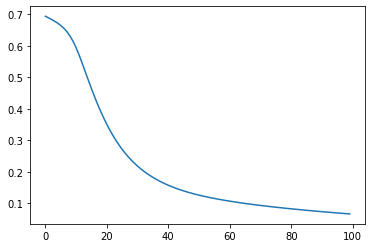

In [28]:
plt.plot(range(len(epoch_losses)),epoch_losses)

In [30]:
for pat in dataset:
    break

In [29]:
pad_packed_sequence(overfit_batch['input_pack'],batch_first=True)[0].dtype

torch.int64

In [59]:
# compute baseline avgprec
positives = overfit_batch['target_sequence'].sum().item()
positives / ( torch.numel(overfit_batch['target_sequence']) - positives)

0.0035460992907801418

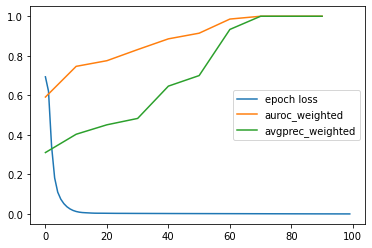

In [21]:
plt.plot(range(len(epoch_losses)),epoch_losses,label='epoch loss');
for e in record_metrics:
    x_coord = [ e * metrics_every for e in range(len(record_metrics[e]))]
    plt.plot(x_coord,record_metrics[e],label=e);
plt.legend();

In [54]:
record_metrics['avgprec_weighted'][-5:]

[0.9555555582046509, 1.0, 1.0, 1.0, 1.0]

## Train the model on dataloader

In [31]:
epochs = 6
n_labels = input_size = dataset.grouping_data['ccs']['n_labels']

epoch_losses = list()

metrics = Metrics(build_default_metrics(n_labels))
record_metrics = {key:list() for key in metrics.metrics}

model = RNN(input_size=input_size,
            hidden_size=150,
            num_layers=1,
            n_labels=n_labels,
            model='gru')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0006)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

ths = {i:0.5 for i in range(n_labels)}

metrics_every = 2
for epoch in tqdm(range(epochs)):
    
    
    if (epoch % metrics_every == 0 and epoch != 0) or epoch == epochs-1:
        

        # compute metrics
        metrics = Metrics(build_default_metrics(n_labels))
        
        res = compute_metrics_dataloader(metrics,model,train_dataloader,ths)
        
        for key in res:
            record_metrics[key].append(res[key])
        print('epoch', epoch)
        print(record_metrics)
        print('\n')
    
    epoch_loss = train_model_dataloader(model,train_dataloader,criterion,optimizer)
    epoch_losses.append(epoch_loss)
    print(epoch_loss)

  0%|          | 0/6 [00:00<?, ?it/s]

Starting to train each batch


0it [00:00, ?it/s]

0.017822475559461787
Starting to train each batch


0it [00:00, ?it/s]

0.01591032616714113
Starting to iterate the dataloader to update metrics


0it [00:00, ?it/s]

Now its time to compute metrics. this may take a while
epoch 2
{'auroc_weighted': [0.7158951163291931], 'avgprec_weighted': [0.06593813002109528]}


Starting to train each batch


0it [00:00, ?it/s]

0.015748051842642316
Starting to train each batch


0it [00:00, ?it/s]

0.01565664486370281
Starting to iterate the dataloader to update metrics


0it [00:00, ?it/s]

Now its time to compute metrics. this may take a while
epoch 4
{'auroc_weighted': [0.7158951163291931, 0.7346497178077698], 'avgprec_weighted': [0.06593813002109528, 0.07223277539014816]}


Starting to train each batch


0it [00:00, ?it/s]

0.01558067461517424
Starting to iterate the dataloader to update metrics


0it [00:00, ?it/s]

Now its time to compute metrics. this may take a while
epoch 5
{'auroc_weighted': [0.7158951163291931, 0.7346497178077698, 0.7390997409820557], 'avgprec_weighted': [0.06593813002109528, 0.07223277539014816, 0.07451707124710083]}


Starting to train each batch


0it [00:00, ?it/s]

0.015522738707845344


In [32]:
compute_metrics_dataloader(Metrics(build_default_metrics(n_labels)),model,val_dataloader,ths)

Starting to iterate the dataloader to update metrics


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


0it [00:00, ?it/s]

Now its time to compute metrics. this may take a while


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/functional/classification/average_precision.py:165: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in average
  warnings.warn(


{'auroc_weighted': 0.7080987691879272, 'avgprec_weighted': 0.06605038791894913}

# test where the model fails

target distribution on validation set

In [57]:
counter= {}
for batch in val_dataloader:
    target = batch['target_sequence']
    counts = target.sum(axis=-1).tolist()
    for c in counts:
        if c not in counter:
            counter[c] = 1
        else:
            counter[c] += 1
pd.concat([pd.Series(counter,name='Count'),pd.Series(counter,name='%').div(pd.Series(counter).sum()).multiply(100)],axis=1).sort_index().round(1).head(5)

,Count,%
0.0,129878,47.9
1.0,68082,25.1
2.0,35643,13.1
3.0,18265,6.7
4.0,9326,3.4


In [ ]:
ths = compute_

In [64]:
ths = {i:0.5 for i in range(n_labels)}

In [115]:
torch.ones(size=(6,3)).sum(axis=0)

tensor([6., 6., 6.])

In [124]:
a = compute_n_preds_dataloader(model,val_dataloader,ths,how='each')

iterating dataloader to compute n_preds


  0%|          | 0/9856 [00:00<?, ?it/s]

In [130]:
pd.Series(a).where(lambda x: x>0).dropna().sort_values(ascending=False)

182    1187.0
183     326.0
241     147.0
245     123.0
261      76.0
246       6.0
124       3.0
224       2.0
89        1.0
dtype: float64

In [128]:
b = compute_positives_dataloader(train_dataloader,how='each')

iterating dataloader to compute n_positives


  0%|          | 0/45992 [00:00<?, ?it/s]

In [131]:
pd.Series(b).where(lambda x: x>0).dropna().sort_values(ascending=False)[:10]

261    72747.0
260    66767.0
245    66036.0
246    59145.0
192    40506.0
198    38021.0
122    35466.0
46     30298.0
225    30254.0
240    28240.0
dtype: float64

In [114]:
compute_prevalence_dataloader(val_dataloader,how='all')

iterating dataloader to compute prevalence


  0%|          | 0/9856 [00:00<?, ?it/s]

0.0038057869000172285

In [77]:
compute_positives_batch(batch,how='all')

tensor(2.)

In [78]:
compute_n_preds_batch(model,batch,{i:0.5 for i in range(n_labels)})

tensor(0)

metrics that require threshold

In [ ]:
assert 1 == 2
thresholds_train = compute_thresholds_dataloader(model,train_dataloader)

In [148]:
thresholds_train

,f1_score,best_thresholds,all_prevalence,all_positives
0,0.126722,2.387159e-02,0.000490,623.0
1,0.121622,1.940342e-02,0.000333,423.0
2,0.031768,1.471390e-02,0.002193,2785.0
3,0.024725,8.945231e-03,0.003207,4073.0
4,0.005865,1.613029e-04,0.000079,100.0
...,...,...,...,...
278,0.008734,2.274197e-05,0.000046,58.0
279,0.000118,6.317161e-07,0.000006,8.0
280,NaN,NaN,0.000000,0.0
281,0.012072,1.144088e-03,0.000136,173.0


In [239]:
metrics = Metrics({'f1_score':F1Score(num_classes=n_labels,average=None,multiclass=False),
                   'avgprec':AveragePrecision(num_classes=n_labels,average=None,multiclass=False),
                   'aucroc':AUROC(num_classes=n_labels,average=None,multiclass=False)
                  })
val_metrics = compute_metrics_dataloader(metrics,model,val_dataloader,thresholds_train['best_thresholds'].to_dict())

Starting to iterate the dataloader to update metrics


  0%|          | 0/9856 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


compare train results with validation results

In [242]:
compare = pd.concat([thresholds_train['f1_score'].rename('f1_train'), # f1_score in train
           pd.Series(val_metrics['f1_score']['each'],name='f1_val') #f1_score in validation
          ],
          axis=1)
compare

,f1_train,f1_val
0,0.126722,0.000000
1,0.121622,0.000000
2,0.031768,0.016721
3,0.024725,0.014264
4,0.005865,0.000000
...,...,...
278,0.008734,0.000000
279,0.000118,0.000000
280,NaN,NaN
281,0.012072,0.000000


In [268]:
pd.set_option('display.max_colwidth', None)
top_performances = compare.sort_values('f1_val',ascending=False).where(lambda row: row.f1_val > 0.2).dropna().index
compare.loc[:,'ccs_code'] = [dataset.grouping_data['ccs']['int2code'][code] for code in compare.index]
compare.loc[:,'description'] = icdmap.lookup('ccstodescription',compare.ccs_code)
compare.sort_values('f1_val',ascending=False).head(5)

,f1_train,f1_val,ccs_code,description
182,0.562331,0.541463,195,Other complications of birth; puerperium affecting management of mother
183,0.343590,0.337722,196,Other pregnancy and delivery including normal
245,0.312846,0.307541,258,Other screening for suspected conditions (not mental disorders or infectious disease)
175,0.248519,0.255063,188,Fetopelvic disproportion; obstruction
261,0.250262,0.237076,670,Miscellaneous mental health disorders


# Figure out what inputs are mostly present when we predict well certain diagnoses

In [406]:
dataset.grouping_data['ccs']['n_labels']

dict_keys(['n_labels', 'sorted', 'int2code', 'code2int', 'int2code_converter'])

In [411]:
def report_history_dist_of_positive_preds(diags : list,model,thresholds:dict,dataloader,dataset,icdmap):
    """
    Given a list of diagnoses, provides an analysis of the history distribution when the model predicts positives for each diagnostic
    """
    
    data = dict()
    
    print('obtaining the distribution of the history for the positive predictions of each diagnostic')
    for diag in tqdm(diags):

        positives_history_dist = torch.zeros(size=(dataset.grouping_data['ccs']['n_labels'],))
        true_positives_history_dist = torch.zeros(size=(dataset.grouping_data['ccs']['n_labels'],))
        false_positives_history_dist = torch.zeros(size=(dataset.grouping_data['ccs']['n_labels'],))
        for batch in tqdm(val_dataloader):
            history = torch.vstack(batch['history_hot'])
            targets = batch['target_sequence']
            preds = compute_model_preds_batch(model,batch,thresholds)

            mask_positives = preds[:,diag] == 1
            mask_true_positives = (preds[:,diag] == 1) & (targets[:,diag] == 1)
            mask_false_positives = (preds[:,diag] == 1) & (targets[:,diag] == 0)

            history_positives = history[mask_positives,:]
            history_true_positives = history[mask_true_positives,:]
            history_false_positives = history[mask_false_positives,:]
            if history_positives.numel() != 0:
                positives_history_dist += history_positives.sum(axis=0)
            if history_true_positives.numel() != 0:
                true_positives_history_dist += history_true_positives.sum(axis=0)
            if history_false_positives.numel() != 0:
                false_positives_history_dist += history_false_positives.sum(axis=0)
        data[diag] = dict(history_dist_positives=positives_history_dist.tolist(),
                          history_dist_true_positives=true_positives_history_dist.tolist(),
                          history_dist_false_positives=false_positives_history_dist.tolist()
                         )
    
    # building report
    report = []
    for diag in data:
        ccs_code = dataset.grouping_data['ccs']['int2code'][diag] # diag was original in int format
        print(f"ccs code {ccs_code} | {icdmap.lookup('ccstodescription',pd.Series(ccs_code)).values[0]}")
        a = pd.DataFrame(data[diag])
        b = a.sort_values('history_dist_positives',ascending=False).loc[:,'history_dist_positives'].to_frame().head(5)#
        b.loc[:,'ccs'] = [dataset.grouping_data['ccs']['int2code'][x] for x in b.index]
        b = b.set_index('ccs')#.rename_axis(index=compare[compare.ccs_code == .loc[e,["ccs_code","description"]].values)
        b = (b.div(b.sum())*100).round(1)
        b = b.astype(str).apply(lambda x: x+'%')
        b.loc[:,'code description'] = [icdmap.lookup('ccstodescription',pd.Series(x)).values[0] for x in b.index]
        report.append(b)
    return report

report = report_history_dist_of_positive_preds([182,183,245,175,261],model,thresholds_train['best_thresholds'].to_dict(),val_dataloader,dataset,icdmap)
for r in report:
    r

obtaining the distribution of the history for the positive predictions of each diagnostic


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/9856 [00:00<?, ?it/s]

  0%|          | 0/9856 [00:00<?, ?it/s]

ccs code 195 | Other complications of birth; puerperium affecting management of mother
ccs code 196 | Other pregnancy and delivery including normal
ccs code 258 | Other screening for suspected conditions (not mental disorders or infectious disease)
ccs code 188 | Fetopelvic disproportion; obstruction
ccs code 670 | Miscellaneous mental health disorders


,history_dist_positives,code description
ccs,,
196,94.5%,Other pregnancy and delivery including normal
182,2.0%,Hemorrhage during pregnancy; abruptio placenta; placenta previa
670,1.4%,Miscellaneous mental health disorders
181,1.2%,Other complications of pregnancy
184,0.9%,Early or threatened labor


,history_dist_positives,code description
ccs,,
195,65.6%,Other complications of birth; puerperium affecting management of mother
661,11.6%,Substance-related disorders
181,10.5%,Other complications of pregnancy
182,6.8%,Hemorrhage during pregnancy; abruptio placenta; placenta previa
177,5.6%,Spontaneous abortion


,history_dist_positives,code description
ccs,,
196,55.5%,Other pregnancy and delivery including normal
195,14.5%,Other complications of birth; puerperium affecting management of mother
175,13.1%,Other female genital disorders
136,12.2%,Disorders of teeth and jaw
670,4.7%,Miscellaneous mental health disorders


,history_dist_positives,code description
ccs,,
196,93.6%,Other pregnancy and delivery including normal
195,4.6%,Other complications of birth; puerperium affecting management of mother
184,1.1%,Early or threatened labor
670,0.4%,Miscellaneous mental health disorders
50,0.3%,Diabetes mellitus with complications


,history_dist_positives,code description
ccs,,
663,55.6%,Screening and history of mental health and substance abuse codes
175,18.7%,Other female genital disorders
169,10.6%,Endometriosis
258,7.9%,Other screening for suspected conditions (not mental disorders or infectious disease)
143,7.2%,Abdominal hernia


In [404]:
for e in data:
    ccs_code = dataset.grouping_data['ccs']['int2code'][e]
    print(f"ccs code {ccs_code} | {compare[compare.ccs_code == ccs_code]['description'].values[0]}")
    a = pd.DataFrame(data[e])
    b = a.sort_values('history_dist_positives',ascending=False).rename_axis(index=f'{compare.loc[e,["ccs_code","description"]].values}').loc[:,'history_dist_positives'].to_frame().head(5)#
    b.loc[:,'ccs'] = [dataset.grouping_data['ccs']['int2code'][x] for x in b.index]
    b = b.set_index('ccs')#.rename_axis(index=compare[compare.ccs_code == .loc[e,["ccs_code","description"]].values)
    b = (b.div(b.sum())*100).round(1)
    b = b.astype(str).apply(lambda x: x+'%')
    b.loc[:,'code description'] = [icdmap.lookup('ccstodescription',pd.Series(x)).values[0] for x in b.index]
    b

ccs code 195 | Other complications of birth; puerperium affecting management of mother


,history_dist_positives,code description
ccs,,
196,94.5%,Other pregnancy and delivery including normal
182,2.0%,Hemorrhage during pregnancy; abruptio placenta; placenta previa
670,1.4%,Miscellaneous mental health disorders
181,1.2%,Other complications of pregnancy
184,0.9%,Early or threatened labor


ccs code 196 | Other pregnancy and delivery including normal


,history_dist_positives,code description
ccs,,
195,67.1%,Other complications of birth; puerperium affecting management of mother
661,11.0%,Substance-related disorders
181,10.0%,Other complications of pregnancy
182,6.4%,Hemorrhage during pregnancy; abruptio placenta; placenta previa
258,5.4%,Other screening for suspected conditions (not mental disorders or infectious disease)


ccs code 258 | Other screening for suspected conditions (not mental disorders or infectious disease)


,history_dist_positives,code description
ccs,,
196,54.3%,Other pregnancy and delivery including normal
195,15.4%,Other complications of birth; puerperium affecting management of mother
175,13.2%,Other female genital disorders
136,12.4%,Disorders of teeth and jaw
670,4.6%,Miscellaneous mental health disorders


ccs code 188 | Fetopelvic disproportion; obstruction


,history_dist_positives,code description
ccs,,
196,93.4%,Other pregnancy and delivery including normal
195,4.8%,Other complications of birth; puerperium affecting management of mother
184,1.1%,Early or threatened labor
670,0.4%,Miscellaneous mental health disorders
50,0.3%,Diabetes mellitus with complications


ccs code 670 | Miscellaneous mental health disorders


,history_dist_positives,code description
ccs,,
663,53.4%,Screening and history of mental health and substance abuse codes
175,18.5%,Other female genital disorders
169,12.7%,Endometriosis
258,8.1%,Other screening for suspected conditions (not mental disorders or infectious disease)
143,7.3%,Abdominal hernia


In [358]:
a.sort_values('history_dist_positives',ascending=False)

,history_dist_positives,history_dist_true_positives,history_dist_false_positives
183,9162.0,3980.0,5182.0
169,197.0,55.0,142.0
261,133.0,52.0,81.0
168,119.0,37.0,82.0
171,88.0,43.0,45.0
...,...,...,...
117,0.0,0.0,0.0
118,0.0,0.0,0.0
119,0.0,0.0,0.0
120,0.0,0.0,0.0


In [ ]:
a.loc[:,182].value_counts(normalize=True).rename(f'{compare.loc[}

# Quick eda

In [283]:
lens = list()
for batch in tqdm(train_dataloader):
    lens.extend(batch['length'])

  0%|          | 0/45992 [00:00<?, ?it/s]

In [304]:
original_dist

,Count,Count after target replication
0,,
1,6172,150149
2,47224,143977
3,26844,96753
4,18908,69909
5,13905,51001
6,10770,37096
7,8803,26326
8,6912,17523
9,5905,10611


In [314]:
original_dist = pd.DataFrame(lens).value_counts().to_frame('Count').sort_index().head(10)
original_dist = pd.concat([original_dist,original_dist.iloc[::-1,0].cumsum().sort_index().rename('Count after target replication')],axis=1)
original_dist = pd.concat([original_dist,
                           original_dist.diff(axis=1).iloc[:,1].div(original_dist['Count']).multiply(100).round(0).astype(int).rename('increase %')
                          ],axis=1).rename_axis(index='Nº timesteps')
original_dist

,Count,Count after target replication,increase %
Nº timesteps,,,
1,6172,150149,2333
2,47224,143977,205
3,26844,96753,260
4,18908,69909,270
5,13905,51001,267
6,10770,37096,244
7,8803,26326,199
8,6912,17523,154
9,5905,10611,80


In [316]:
print(original_dist.to_latex())

\begin{tabular}{lrrr}
\toprule
   &  Count &  Count after target replication &  increase \% \\
Nº timesteps &        &                                 &             \\
\midrule
1  &   6172 &                          150149 &        2333 \\
2  &  47224 &                          143977 &         205 \\
3  &  26844 &                           96753 &         260 \\
4  &  18908 &                           69909 &         270 \\
5  &  13905 &                           51001 &         267 \\
6  &  10770 &                           37096 &         244 \\
7  &   8803 &                           26326 &         199 \\
8  &   6912 &                           17523 &         154 \\
9  &   5905 &                           10611 &          80 \\
10 &   4706 &                            4706 &           0 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_26521/3328194530.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(original_dist.to_latex())


# Evaluate performance at different levels

using the lengths of each batch I must select only the appropriate logits&prediction rows

In [ ]:
a = [1,2,3,4,5,6]
level = 3
leng = 6
range(3,leng)

In [595]:
res = {}
levels = [1,5,10]
for level in tqdm(levels):
    metrics = Metrics({'avgprec':AveragePrecision(num_classes=n_labels,average=None,multiclass=False),
                       'f1score':F1Score(num_classes=n_labels,average=None,multiclass=False)
                      })
    n_seqs = 0
    total_n_seqs = 0
    for batch in tqdm(val_dataloader):
        lengths = batch['length']
        target = batch['target_sequence']
        logits = compute_model_logits_batch(model,batch)
        
        mask = mask_at_k(lengths,level)
        
        # stats
        n_seqs += len(mask)
        total_n_seqs += len(lengths)
        if mask:
            relevant_logits = logits[mask,:]
            relevant_target = target[mask,:]
            relevant_preds = logits2preds(relevant_logits,new_level10_thresholds['best_thresholds'].to_dict())

            metrics.update(relevant_logits,relevant_preds,relevant_target)
            
    res[level]=dict(metrics=metrics.compute(),n_seqs=n_seqs,total_n_seqs=total_n_seqs)

  0%|          | 0/3 [00:00<?, ?it/s]

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/9856 [00:00<?, ?it/s]

  0%|          | 0/9856 [00:00<?, ?it/s]

  0%|          | 0/9856 [00:00<?, ?it/s]

In [597]:
all_levels = list()
for level in res:
    all_metrics = list()
    for metric in res[level]['metrics']:
        a = pd.DataFrame([res[level]['metrics'][metric]['weighted']],index=[level],columns=[metric])
        all_metrics.append(a)
        
    p_dataset = round(res[level]['n_seqs'] / res[level]['total_n_seqs'] * 100,1)
    all_metrics.append(pd.DataFrame([p_dataset],index=[level],columns=['portion of patients eligible (%)']).astype(str).apply(lambda x: x+'%'))
    all_levels.append(pd.concat(all_metrics,axis=1))
    
a = pd.concat(all_levels).rename_axis(index='HISTORY SIZE')#[['avgprec','portion of patients eligible (%)']]
a
#change = (a[res[level]['metrics']].diff().div(a[res[level]['metrics']].shift(1))*100).round(1).astype(str)#.apply(lambda x: "+"+x + "%").rename('avgprec change (%)')
#change

#pd.concat([a,change],axis=1)[['avgprec','avgprec change (%)','portion of patients eligible (%)']]

,avgprec,f1score,portion of patients eligible (%)
HISTORY SIZE,,,
1,0.064567,0.112626,100.0%
5,0.071649,0.106474,45.7%
10,0.074842,0.112191,20.9%


/tmp/ipykernel_26521/160805554.py:14: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  change = (a[res[level]['metrics']].diff().div(a[res[level]['metrics']].shift(1))*100).round(1).astype(str)#.apply(lambda x: "+"+x + "%").rename('avgprec change (%)')
/tmp/ipykernel_26521/160805554.py:14: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  change = (a[res[level]['metrics']].diff().div(a[res[level]['metrics']].shift(1))*100).round(1).astype(str)#.apply(lambda x: "+"+x + "%").rename('avgprec change (%)')


,avgprec,f1score
HISTORY SIZE,,
1,nan,nan
5,11.0,-5.5
10,4.5,5.4


Será que este tipo de improvement significa algo a nivel individual?

In [601]:
a = pd.Series(res[10]['metrics']['f1score']['each']).sort_values(ascending=False).head(10).to_frame('f1score of predictions when history=10 timesteps')
a.loc[:,'ccs_code'] = [dataset.grouping_data['ccs']['int2code'][x] for x in a.index]
a.loc[:,'description'] = icdmap.lookup('ccstodescription',a['ccs_code'])
a

,f1score of predictions when history=10 timesteps,ccs_code,description
182,0.551075,195,Other complications of birth; puerperium affecting management of mother
183,0.447761,196,Other pregnancy and delivery including normal
245,0.397716,258,Other screening for suspected conditions (not mental disorders or infectious disease)
89,0.375000,101,Coronary atherosclerosis and other heart disease
175,0.300000,188,Fetopelvic disproportion; obstruction
241,0.238095,254,Rehabilitation care; fitting of prostheses; and adjustment of devices
104,0.222222,116,Aortic and peripheral arterial embolism or thrombosis
261,0.201135,670,Miscellaneous mental health disorders
246,0.188964,259,Residual codes; unclassified
260,0.172637,663,Screening and history of mental health and substance abuse codes


In [588]:
a = pd.Series(res[10]['metrics']['avgprec']['each']).sort_values(ascending=False).head(10).to_frame('avg_prec of predictions when history=10 timesteps')
a.loc[:,'ccs_code'] = [dataset.grouping_data['ccs']['int2code'][x] for x in a.index]
a.loc[:,'description'] = icdmap.lookup('ccstodescription',a['ccs_code'])
a

,avg_prec of predictions when history=10 timesteps,ccs_code,description
182,0.384586,195,Other complications of birth; puerperium affecting management of mother
183,0.351068,196,Other pregnancy and delivery including normal
245,0.310059,258,Other screening for suspected conditions (not mental disorders or infectious disease)
89,0.243851,101,Coronary atherosclerosis and other heart disease
175,0.222179,188,Fetopelvic disproportion; obstruction
261,0.164095,670,Miscellaneous mental health disorders
246,0.136884,259,Residual codes; unclassified
241,0.118124,254,Rehabilitation care; fitting of prostheses; and adjustment of devices
260,0.114825,663,Screening and history of mental health and substance abuse codes
149,0.096447,162,Other diseases of bladder and urethra


looks promising. What about computing thresholds only on these patients?

In [593]:
new_level10_thresholds = compute_thresholds_dataloader(model,train_dataloader,at_timestep=10)

Iterating the dataloader to obtain the logits and targets


  0%|          | 0/45992 [00:00<?, ?it/s]

Computing the thresholds for each of the 283 diagnostics


  0%|          | 0/283 [00:00<?, ?it/s]

/tmp/ipykernel_26521/3504196956.py:36: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/tmp/ipykernel_26521/3504196956.py:36: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/tmp/ipykernel_26521/3504196956.py:36: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/tmp/ipykernel_26521/3504196956.py:36: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/tmp/ipykernel_26521/3504196956.py:36: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/tmp/ipykernel_26521/3504196956.py:36: RuntimeWarning: invalid value encountered in true_divide
  f1score

In [ ]:
report_history_dist_of_positive_preds(best_diags,model,thresholds_train['best_thresholds'],val_dataloader,dataset,icdmap)

# Wandb for training on different timesteps

In [91]:
dataset = ICareDataset(dataset_folder,
                            ccs_universe,
                            grouping,
                          )

val_dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            collate_fn=ICareCOLLATE(input,target),
                            sampler=SubsetRandomSampler(dataset.val_indices)
                           )

processing each patient


  0%|          | 0/262811 [00:00<?, ?it/s]

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/snovaisg/icare-timesteps/g0t59ed2/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/snovaisg/icare-timesteps/g0t59ed2/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/snovaisg/icare-timesteps/g0t59ed2/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client Error: Not Found for url: https://api.wandb.ai/files/snovaisg/icare-timesteps/g0t59ed2/file_stream
NoneType: None
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
ERROR:root:dropped chunk 404 Client

In [92]:
#import wandb

wandb.init(project="icare_timesteps", entity="snovaisg")

In [93]:
def build_metrics(n_labels):
    return {
           'auroc':AUROC(num_classes=n_labels,average=None,multiclass=False),
           'avgprec':AveragePrecision(num_classes=n_labels,average=None,multiclass=False),
           'f1score':F1Score(num_classes=n_labels,average=None,multiclass=False)
           }

In [94]:
Uparams = dict(hidden_size=[150],
               lr=[0.0006],
               num_layers=[1],
               batch_size=[8],
               model_type=['gru'],
               train_regime=[dict(mode='above',k=3),dict(mode='above',k=5),dict(mode='above',k=10),dict(mode=None,k=1)]
              )

params = list(ParameterGrid(Uparams))

reproducibility

In [95]:
# Reproducibility
seed = settings.random_seed

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# hey mr meeseeks look at me!!!!

In [96]:
input = 'history_hot' #one hot encoding of history as opposed to multi-hot
output = 'new_target_hot'

grouping = 'ccs'
ccs_universe = list(icdmap.icd9_3toccs.data.keys())

In [ ]:
# weird workaround when i need to stop in the middle and not have to redo computation
already_done = -1

epochs = 10

n_labels = input_size = dataset.grouping_data['ccs']['n_labels']

# when to compute metrics and performance on validation set
train_metrics_every = val_metrics_every = 10000

criterion = nn.BCEWithLogitsLoss(reduction='mean')

metrics_selectors = [MaskTimesteps('above',3),MaskTimesteps('above',5),MaskTimesteps('above',10),MaskTimesteps('above',1)]

# relevant stats when using df.describe() on the top 10 diagnoses
relevant_stats = ["mean","std","min","25%","50%","75%","max"]
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for idx,param_set in enumerate(tqdm(params)):
        if idx < already_done:
            continue

        timestep_mode = param_set['train_regime']['mode']
        timestep_k = param_set['train_regime']['k']
        if timestep_mode is None:
            train_timestep_selector = None
        else:
            train_timestep_selector = MaskTimesteps(timestep_mode,timestep_k)

        model = RNN(input_size=input_size,
                hidden_size=param_set['hidden_size'],
                num_layers=param_set['num_layers'],
                n_labels=n_labels,
                model=param_set['model_type'])

        optimizer = torch.optim.Adam(model.parameters(), lr=param_set['lr'])

        train_dataloader = DataLoader(dataset,
                                batch_size=param_set['batch_size'],
                                collate_fn=ICareCOLLATE(input,output),
                                sampler=SubsetRandomSampler(dataset.train_indices)
                               )

        config = {
          "batch_size": param_set['batch_size'],
          "epochs": epochs,
          "input":'ccs',
          "output":'ccs',
          "name":"baseline model",
          "manual_seed":seed,
            "hidden_size":param_set['hidden_size'],
            "num_layers":param_set['num_layers'],
            "model":param_set['model_type'],
            "lr":param_set["lr"],
            "mode":param_set['train_regime']['mode'],
            "mode@k":param_set['train_regime']['k']

        }

        wandb.init(project="icare_timesteps", entity="snovaisg",config=config)

        print('Starting to train each epoch')
        for epoch in tqdm(range(epochs)):

            train_loss = train_model_dataloader(model,train_dataloader,criterion,optimizer,train_timestep_selector)

            log = {'train_loss':train_loss,
                   'epoch':epoch
                  }

            if (epoch % train_metrics_every == 0 and epoch != 0) or epoch == epochs -1:

                print('Starting to iterate each timestep selector to compute metrics')
                for selector in tqdm(metrics_selectors):
                    selector_prefix = f'above_{selector.k}_'
                    # compute train metrics
                    train_prefix = 'train_'
                    metrics = Metrics(build_metrics(n_labels))

                    thresholds = compute_thresholds_dataloader(model,train_dataloader,selector)

                    train_metrics = compute_metrics_dataloader(metrics,model,train_dataloader,thresholds['best_thresholds'].to_dict(),selector)
                    top10_prefix = 'top_10_'
                    for m in train_metrics:
                        data_each = train_metrics[m]['each']
                        # get stats of top 10 performing diagnostics
                        top10_stats = pd.Series(data_each).nlargest(10).describe().loc[relevant_stats].to_dict()
                        top10_stats = {selector_prefix+train_prefix+m+'_'+top10_prefix+k:top10_stats[k] for k in top10_stats} #EG.: above_3_train_f1score_top10_median:0.23118
                        log.update(top10_stats)

                        weighted_prefix  = 'weighted_'
                        data_weighted = {selector_prefix+train_prefix+m+weighted_prefix: train_metrics[m]['weighted']}
                        log.update(data_weighted)

                    # compute val stats
                    val_prefix = 'val_'
                    val_loss = compute_loss_dataloader(model,val_dataloader,criterion,train_timestep_selector)

                    # compute val metrics
                    metrics = Metrics(build_metrics(n_labels))

                    val_metrics = compute_metrics_dataloader(metrics,model,val_dataloader,thresholds['best_thresholds'].to_dict(),selector)

                    top10_prefix = 'top_10_'
                    for m in val_metrics:
                        data_each = val_metrics[m]['each']
                        # get stats of top 10 performing diagnostics
                        top10_stats = pd.Series(data_each).nlargest(10).describe().loc[relevant_stats].to_dict()
                        top10_stats = {selector_prefix+val_prefix+m+'_'+top10_prefix+k:top10_stats[k] for k in top10_stats} #EG.: above_3_train_f1score_top10_median:0.23118
                        log.update(top10_stats)

                        weighted_prefix  = 'weighted_'
                        data_weighted = {selector_prefix+val_prefix+m+weighted_prefix: val_metrics[m]['weighted']}
                        log.update(data_weighted)

            wandb.log(log)

  0%|          | 0/4 [00:00<?, ?it/s]

Starting to train each epoch


  0%|          | 0/10 [00:00<?, ?it/s]

Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

# Experiment with loss and criterion

lets train a model

In [81]:
epochs = 10
n_labels = input_size = dataset.grouping_data['ccs']['n_labels']

epoch_losses = list()

metrics = Metrics(build_default_metrics(n_labels))
record_metrics = {key:list() for key in metrics.metrics}

model = RNN(input_size=input_size,
            hidden_size=150,
            num_layers=1,
            n_labels=n_labels,
            model='gru')

optimizer = torch.optim.Adam(model.parameters(), lr=0.0006)
criterion = nn.BCEWithLogitsLoss(reduction='mean')

epoch_losses = list()
for epoch in range(epochs):
    epoch_loss = train_model_dataloader(model,train_dataloader,criterion,optimizer)
    epoch_losses.append(epoch_loss)
    print(epoch_loss)
#val_loss = compute_loss_dataloader(model,val_dataloader,criterion)

Starting to train each batch


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/175 [00:00<?, ?it/s]

0.22821717864700727
Starting to train each batch


  0%|          | 0/175 [00:00<?, ?it/s]

0.060636585780552456
Starting to train each batch


  0%|          | 0/175 [00:00<?, ?it/s]

0.04056273436972073
Starting to train each batch


  0%|          | 0/175 [00:00<?, ?it/s]

0.03223854790308646
Starting to train each batch


  0%|          | 0/175 [00:00<?, ?it/s]

0.0286244141629764
Starting to train each batch


  0%|          | 0/175 [00:00<?, ?it/s]

0.026436903311737946
Starting to train each batch


  0%|          | 0/175 [00:00<?, ?it/s]

0.024544021162603583
Starting to train each batch


  0%|          | 0/175 [00:00<?, ?it/s]

0.02305209243670106
Starting to train each batch


  0%|          | 0/175 [00:00<?, ?it/s]

0.022767762837133238
Starting to train each batch


  0%|          | 0/175 [00:00<?, ?it/s]

0.021280657327068703


In [90]:
def compute_loss_decomposed(model,dataloader,criterion):
    loss_positives = list()
    loss_negatives = list()
    loss = list()
    for batch in tqdm(dataloader):

        lengths = batch['length']
        input = batch['input_pack']
        targets = batch['target_sequence']

        outs = model(input,ignore_sigmoid=True)
        outs = outs2nonpadded(outs,lengths)

        idx_positives = torch.where(targets.sum(axis=1) > 0)[0]
        outs_positives = outs[idx_positives,:]
        targets_positives = targets[idx_positives,:]
        loss_positives.append(criterion(outs_positives,targets_positives).item())

        idx_negatives = torch.where(targets.sum(axis=1) == 0)[0]
        outs_negatives = outs[idx_negatives,:]
        targets_negatives = targets[idx_negatives,:]
        loss_negatives.append(criterion(outs_negatives,targets_negatives).item())

        loss.append(criterion(outs,targets).item())
    return {'loss':np.nanmean(loss),
            'loss_positives':np.nanmean(loss_positives),
            'loss_negatives':np.nanmean(loss_negatives)
           }

In [91]:
compute_loss_decomposed(model,train_dataloader,BCEWithLogitsLoss())

  0%|          | 0/175 [00:00<?, ?it/s]

{'loss': 0.020042253801865237,
 'loss_positives': 0.03596009632755566,
 'loss_negatives': 0.005167442693242005}

# Wandb for ignoring targets vs not

In [18]:
dataset_folder = '/home/debian/Simao/master-thesis/data/model_ready_dataset/icare2021_diag_A301/dataset_added_new_targets.json'

input = 'history_hot' #one hot encoding of history as opposed to multi-hot
target = 'new_target_hot'

grouping = 'ccs'
ccs_universe = list(icdmap.icd9_3toccs.data.keys())

dataset = ICareDataset(dataset_folder,
                            ccs_universe,
                            grouping,
                          )

processing each patient


  0%|          | 0/262811 [00:00<?, ?it/s]

In [ ]:
#import wandb

wandb.init(project="icare_ignore_targets", entity="snovaisg")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: snovaisg. Use `wandb login --relogin` to force relogin


In [ ]:
def build_metrics(n_labels):
    return {
           'avgprec':AveragePrecision(num_classes=n_labels,average=None,multiclass=False),
           #'f1score':F1Score(num_classes=n_labels,average=None,multiclass=False)
           }

In [ ]:
Uparams = dict(hidden_size=[150,200],
               lr=[0.0006,0.002],
               num_layers=[1],
               batch_size=[4,8],
               model_type=['rnn'],
               ignore_target=[False,True]
              )

params = list(ParameterGrid(Uparams))

reproducibility

In [ ]:
# Reproducibility
seed = settings.random_seed

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# hey mr meeseeks look at me!!!!

In [ ]:
val_dataloader = DataLoader(dataset,
                            batch_size=32,
                            collate_fn=ICareCOLLATE(input,target),
                            sampler=SubsetRandomSampler(dataset.val_indices)
                           )

In [ ]:
# weird workaround when i need to stop in the middle and not have to redo computation
already_done = 2

epochs = 10

n_labels = input_size = dataset.grouping_data['ccs']['n_labels']

# when to compute metrics and performance on validation set
train_metrics_every = val_metrics_every = 10000

criterion = nn.BCEWithLogitsLoss(reduction='mean')

metrics_selectors = [MaskTimesteps('below',3),MaskTimesteps('above',3),MaskTimesteps('above',1)]

# relevant stats when using df.describe() on the top 10 diagnoses
relevant_stats = ["mean","std","min","25%","50%","75%","max"]
relevant_stats = ["50%"]
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for idx,param_set in enumerate(tqdm(params)):
        if idx < already_done:
            continue

        model = RNN(input_size=input_size,
                hidden_size=param_set['hidden_size'],
                num_layers=param_set['num_layers'],
                n_labels=n_labels,
                model=param_set['model_type'])

        optimizer = torch.optim.Adam(model.parameters(), lr=param_set['lr'])

        train_dataloader = DataLoader(dataset,
                                batch_size=param_set['batch_size'],
                                collate_fn=ICareCOLLATE(input,target),
                                sampler=SubsetRandomSampler(dataset.train_indices)
                               )

        config = {
          "batch_size": param_set['batch_size'],
          "epochs": epochs,
          "input":'ccs',
          "output":'ccs',
          "name":"baseline model",
          "manual_seed":seed,
            "hidden_size":param_set['hidden_size'],
            "num_layers":param_set['num_layers'],
            "model":param_set['model_type'],
            "lr":param_set["lr"],
            "ignore_empty_targets":param_set["ignore_target"]

        }

        wandb.init(project="icare_ignore_targets", entity="snovaisg",config=config)

        print('Starting to train each epoch')
        for epoch in tqdm(range(epochs)):

            train_loss = train_model_dataloader(model,train_dataloader,criterion,optimizer,ignore_empty_targets=param_set["ignore_target"])

            log = {'train_loss':train_loss,
                   'epoch':epoch
                  }

            if (epoch % train_metrics_every == 0 and epoch != 0) or epoch == epochs -1:

                print('Starting to iterate each timestep selector to compute metrics')
                for selector in tqdm(metrics_selectors):
                    selector_prefix = f'{selector.mode}_{selector.k}_'
                    # compute train metrics
                    train_prefix = 'train_'
                    metrics = Metrics(build_metrics(n_labels))

                    thresholds = {i:0.5 for i in range(n_labels)}

                    train_metrics = compute_metrics_dataloader(metrics,model,train_dataloader,thresholds,selector)
                    top10_prefix = 'top_10_'
                    for m in train_metrics:
                        data_each = train_metrics[m]['each']
                        # get stats of top 10 performing diagnostics
                        top10_stats = pd.Series(data_each).nlargest(10).describe().loc[relevant_stats].to_dict()
                        top10_stats = {selector_prefix+train_prefix+m+'_'+top10_prefix+k:top10_stats[k] for k in top10_stats} #EG.: above_3_train_f1score_top10_median:0.23118
                        log.update(top10_stats)

                        weighted_prefix  = 'weighted_'
                        data_weighted = {selector_prefix+train_prefix+m+weighted_prefix: train_metrics[m]['weighted']}
                        log.update(data_weighted)

                    # compute val stats
                    val_prefix = 'val_'
                    val_loss = compute_loss_dataloader(model,val_dataloader,criterion)

                    # compute val metrics
                    metrics = Metrics(build_metrics(n_labels))

                    val_metrics = compute_metrics_dataloader(metrics,model,val_dataloader,thresholds,selector)

                    top10_prefix = 'top_10_'
                    for m in val_metrics:
                        data_each = val_metrics[m]['each']
                        # get stats of top 10 performing diagnostics
                        top10_stats = pd.Series(data_each).nlargest(10).describe().loc[relevant_stats].to_dict()
                        top10_stats = {selector_prefix+val_prefix+m+'_'+top10_prefix+k:top10_stats[k] for k in top10_stats} #EG.: above_3_train_f1score_top10_median:0.23118
                        log.update(top10_stats)

                        weighted_prefix  = 'weighted_'
                        data_weighted = {selector_prefix+val_prefix+m+weighted_prefix: val_metrics[m]['weighted']}
                        log.update(data_weighted)

            wandb.log(log)

  0%|          | 0/16 [00:00<?, ?it/s]

Starting to train each epoch


  0%|          | 0/10 [00:00<?, ?it/s]

Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while
Starting to iterate the dataloader to update metrics


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Now its time to compute metrics. this may take a while


above_1_train_avgprec_top_10_50%,▁
above_1_train_avgprecweighted_,▁
above_1_val_avgprec_top_10_50%,▁
above_1_val_avgprecweighted_,▁
above_3_train_avgprec_top_10_50%,▁
above_3_train_avgprecweighted_,▁
above_3_val_avgprec_top_10_50%,▁
above_3_val_avgprecweighted_,▁
below_3_train_avgprec_top_10_50%,▁
below_3_train_avgprecweighted_,▁
below_3_val_avgprec_top_10_50%,▁


Starting to train each epoch


  0%|          | 0/10 [00:00<?, ?it/s]

Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while
Starting to iterate the dataloader to update metrics


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while
Starting to iterate the dataloader to update metrics


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while
Starting to iterate the dataloader to update metrics


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while
Starting to iterate the dataloader to update metrics


  0%|          | 0/45992 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while
Starting to iterate the dataloader to update metrics


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while
Starting to iterate the dataloader to update metrics


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while
Starting to iterate the dataloader to update metrics


  0%|          | 0/22996 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while


above_1_train_avgprec_top_10_50%,▁
above_1_train_avgprecweighted_,▁
above_1_val_avgprec_top_10_50%,▁
above_1_val_avgprecweighted_,▁
above_3_train_avgprec_top_10_50%,▁
above_3_train_avgprecweighted_,▁
above_3_val_avgprec_top_10_50%,▁
above_3_val_avgprecweighted_,▁
below_3_train_avgprec_top_10_50%,▁
below_3_train_avgprecweighted_,▁
below_3_val_avgprec_top_10_50%,▁


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while
Starting to iterate the dataloader to update metrics


  0%|          | 0/22996 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to iterate each timestep selector to compute metrics


  0%|          | 0/3 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to iterate each timestep selector to compute metrics


  0%|          | 0/3 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while
Starting to iterate the dataloader to update metrics


  0%|          | 0/22996 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to train each batch


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Starting to iterate each timestep selector to compute metrics


  0%|          | 0/3 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/22996 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while
Starting to compute the loss on the dataloader


  0%|          | 0/1232 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


  0%|          | 0/1232 [00:00<?, ?it/s]

Now its time to compute metrics. this may take a while
Starting to iterate the dataloader to update metrics


  0%|          | 0/22996 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Compute thresholds to evaluate f1 score

-----

In [475]:
thresholds = compute_thresholds(train_dataloader,model)

iterating the dataloader to obtain logits and targets


  0%|          | 0/45992 [00:00<?, ?it/s]

Done.
Computing the best threshold (max f1) for each diagnostic


  0%|          | 0/283 [00:00<?, ?it/s]

/tmp/ipykernel_31002/3155691957.py:26: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/tmp/ipykernel_31002/3155691957.py:26: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/tmp/ipykernel_31002/3155691957.py:26: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/tmp/ipykernel_31002/3155691957.py:26: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/tmp/ipykernel_31002/3155691957.py:26: RuntimeWarning: invalid value encountered in true_divide
  

Done


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


performance on train and validation set

In [489]:
#one for each diagnostic
def build_more_metrics(n_labels):
    return {#'recall_micro': Recall(num_classes=n_labels,average='micro',multiclass=False),
           'recall_weigthed': Recall(num_classes=n_labels,average='weighted',multiclass=False),
           #'precision_micro': Precision(num_classes=n_labels,average='micro',multiclass=False),
           'precision_weighted': Precision(num_classes=n_labels,average='weighted',multiclass=False),
           'f1score_weighted':F1Score(num_classes=n_labels,average='weighted',multiclass=False),
           'accuracy_weighted': Accuracy(num_classes=n_labels,average='weighted',multiclass=False),
           #'f1score_macro':F1Score(num_classes=n_labels,average='macro',multiclass=False),
           'auroc_weighted':AUROC(num_classes=n_labels,average='weighted',multiclass=False),
           'avgprec_weighted':AveragePrecision(num_classes=n_labels,average='weighted',multiclass=False)
          }

metrics = Metrics(build_more_metrics(n_labels))
sets = {'train':train_dataloader,'val':val_dataloader}
res = {}
for dataloader in tqdm(sets):
    if dataloader == 'train':
        continue # takes too long
    metrics = Metrics(build_more_metrics(n_labels))
    res[dataloader] = compute_metrics_dataloader(metrics,model,sets[dataloader],thresholds['threshold'].to_dict())

  0%|          | 0/2 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


0it [00:00, ?it/s]

Now its time to compute metrics. this may take a while


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/functional/classification/average_precision.py:165: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in average
  warnings.warn(


In [ ]:
compute_metrics_dataloader(metrics, model, dataloader, thresholds)

----

----

# Performance on new discoveries

It's easy and maybe not that useful for a model to predict a diagnostic that has been assigned in the past. 

What about the performance everytime the model predicts a new diagnostic that doesn't belong in the patient's history?

Let's load up the validation data

In [82]:
all_target = []
all_history = []
for batch in tqdm(iter(val_dataloader)):
    all_target.append(batch['target_sequence'])
    all_history.append(torch.vstack(batch['history_mhot']))
    
all_target = torch.vstack(all_target)
all_history = torch.vstack(all_history)

  0%|          | 0/9856 [00:00<?, ?it/s]

onde é que interessa avaliar Quais são os meus datapoints?

Vamos pensar numa doença de cada vez. tenho dois vetores que me vão ajudar a perceber onde avaliar. 

quando existe no histórico não me interessa saber se existe no target basicamente. Então crio uma máscara!

In [83]:
not_in_history = all_history == 0

Ok now what? Para cada diagnóstico selecionamos apenas as rows da máscara e avaliamos a performance aí.

Vamos também dar keep track do tamanho original, 1s originais, 0s originais, e o estado final.

In [87]:
info = {}
info_df = pd.DataFrame(index=range(all_history.shape[1]),columns = ['og_size','new_size','og_positives', 'new_positives','og_prevalence','new_prevalence','size_reduction','positive_reduction','prevalence_change'])
info_df.index.name = 'CCS code2int'

for diag in tqdm(range(all_history.shape[1])):
    mask_diag = not_in_history[:,diag]
    relevant_history = all_history[:,diag][mask_diag]
    relevant_target = all_target[:,diag][mask_diag]
    
    diag_info = {}
    
    diag_info['og_size'] = all_history.shape[0]
    info_df.loc[diag,'og_size'] = diag_info['og_size']
    
    diag_info['new_size'] = mask_diag.sum().item()
    info_df.loc[diag,'new_size'] = diag_info['new_size']
    
    
    diag_info['size_reduction'] = ((diag_info['og_size'] - diag_info['new_size']) / diag_info['og_size'])
    info_df.loc[diag,'size_reduction'] = diag_info['size_reduction']
    
    diag_info['og_positives'] = all_target[:,diag].sum().item()
    info_df.loc[diag,'og_positives'] = diag_info['og_positives']
    
    diag_info['new_positives'] = relevant_target.sum().item()
    info_df.loc[diag,'new_positives'] = diag_info['new_positives']
    
    diag_info['positive_reduction'] = (( diag_info['og_positives'] - diag_info['new_positives']) / diag_info['og_positives']) if diag_info['og_positives'] != 0 else np.nan
    info_df.loc[diag,'positive_reduction'] = diag_info['positive_reduction']
    
    
    diag_info['og_prevalence'] = (all_target[:,diag].sum() / all_target.shape[0]).item()
    info_df.loc[diag,'og_prevalence'] = diag_info['og_prevalence']
    
    diag_info['new_prevalence'] = (diag_info['new_positives'] / relevant_target.shape[0]) if relevant_target.shape[0] != 0 else np.nan
    info_df.loc[diag,'new_prevalence'] = diag_info['new_prevalence']
    
    diag_info['prevalence_change'] = ((diag_info['new_prevalence'] - diag_info['og_prevalence']) / diag_info['og_prevalence']) if diag_info['og_prevalence'] != 0 else np.nan
    info_df.loc[diag,'prevalence_change'] = diag_info['prevalence_change']
    
info_df['ccs'] = info_df.index.map(lambda x: dataset.grouping_data['ccs']['int2code'][x]).values

info_df.head(5)
info_df.shape

  0%|          | 0/283 [00:00<?, ?it/s]

,og_size,new_size,og_positives,new_positives,og_prevalence,new_prevalence,size_reduction,positive_reduction,prevalence_change,ccs
CCS code2int,,,,,,,,,,
0,271140,271005,375.0,302.0,0.001383,0.001114,0.000498,0.194667,-0.194265,1
1,271140,271112,95.0,92.0,0.00035,0.000339,0.000103,0.031579,-0.031479,2
2,271140,270883,703.0,646.0,0.002593,0.002385,0.000948,0.081081,-0.080209,3
3,271140,270622,982.0,924.0,0.003622,0.003414,0.00191,0.059063,-0.057262,4
4,271140,271124,21.0,18.0,0.000077,0.000066,0.000059,0.142857,-0.142807,5


(283, 10)

Some diagnostics lost a lot of positives in the target

In [88]:
info_df.sort_values('positive_reduction',ascending=False).head(5)

,og_size,new_size,og_positives,new_positives,og_prevalence,new_prevalence,size_reduction,positive_reduction,prevalence_change,ccs
CCS code2int,,,,,,,,,,
11,271140,270996,183.0,59.0,0.000675,0.000218,0.000531,0.677596,-0.677424,12
183,271140,259196,15202.0,5719.0,0.056067,0.022064,0.044051,0.6238,-0.606464,196
29,271140,271054,116.0,48.0,0.000428,0.000177,0.000317,0.586207,-0.586076,30
23,271140,268388,4023.0,1732.0,0.014837,0.006453,0.01015,0.569476,-0.565061,24
28,271140,268775,3283.0,1448.0,0.012108,0.005387,0.008722,0.55894,-0.555059,29


# Implement in the pipeline ignoring certain rows

## Baseline - do it all at once

Now we are forced to create a metric for each diagnostic since the size of the dataset varies among diagnostics now

In [446]:
# create a metric for each diagnostic
metrics = {code:build_default_metrics(n_labels) for code in range(n_labels)};

In [447]:
val_metrics_new = {code:dict(auroc=AUROC(),
                     avgprec=AveragePrecision(),
                     accuracy=Accuracy(threshold=df.loc[code,'threshold']),
                     precision=Precision(threshold=df.loc[code,'threshold']),
                     recall=Recall(threshold=df.loc[code,'threshold']),
                     f1_score=F1Score(threshold=df.loc[code,'threshold'])
                    ) for code in range(n_labels)}

cols_of_interest = ["positives","prevalence"]

for code in tqdm(val_metrics_new):
    for metric in val_metrics_new[code]:
        
        
        # select only relevant targets with our magic mask
        target = all_target[:,code][not_in_history[:,code]].int()
        input = all_logits[:,code][not_in_history[:,code]]
            
        val_metrics_new[code][metric] = val_metrics_new[code][metric](input,target).item()

  0%|          | 0/283 [00:00<?, ?it/s]

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


In [448]:
df_val_new = pd.DataFrame(val_metrics_new).T
df_val_new.sort_values('f1_score',ascending=False).head(3)
df_val_new.shape

,auroc,avgprec,accuracy,precision,recall,f1_score
23,0.963146,0.751778,0.993506,0.780080,0.783797,0.781934
183,0.968519,0.767715,0.972615,0.742357,0.786038,0.763573
11,0.973326,0.712160,0.999701,0.844595,0.683060,0.755287


(283, 6)

Merging it all together

In [449]:
a = info_df[['size_reduction','prevalence_change']]
a.loc[:,'size_reduction'] = a.size_reduction.apply(lambda x: -1 * x)
a.head(5)

/tmp/ipykernel_31002/358604710.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a.loc[:,'size_reduction'] = a.size_reduction.apply(lambda x: -1 * x)


,size_reduction,prevalence_change
CCS code2int,,
0,-0.000498,-0.194265
1,-0.000103,-0.031479
2,-0.000948,-0.080209
3,-0.001910,-0.057262
4,-0.000059,-0.142807


In [450]:
all_info = {code:dict() for code in val_metrics_new}

original_val_columns = []
for code in tqdm(val_metrics_new):
    
    for col in df_val.columns:
        name = 'og_' + col if 'og' not in col else col
        all_info[code][name] = df_val.loc[code,col]
    
    for col in df_val_new.columns:
        name = 'new_' + col if 'new' not in col else col
        all_info[code][name] = df_val_new.loc[code,col]
    
    for col in info_df.columns:
        all_info[code][col] = info_df.loc[code,col]

all_info = pd.DataFrame(all_info).T
all_info = all_info.rename_axis(index='ccs code2int')
all_info.head(3)
all_info.shape

  0%|          | 0/283 [00:00<?, ?it/s]

,og_auroc,og_avgprec,og_accuracy,og_precision,og_recall,og_f1_score,og_prevalence,og_positives,new_auroc,new_avgprec,...,new_recall,new_f1_score,og_size,new_size,new_positives,new_prevalence,size_reduction,positive_reduction,prevalence_change,ccs
ccs code2int,,,,,,,,,,,,,,,,,,,,,
0,0.802070,0.145341,0.998635,0.519380,0.178667,0.265873,0.001383,375.000000,0.802096,0.145347,...,0.178667,0.265873,271140.000000,271005.000000,302.000000,0.001114,0.000498,0.194667,-0.194265,1.000000
1,0.797878,0.002498,0.998414,0.005900,0.021053,0.009217,0.000350,95.000000,0.797888,0.002498,...,0.021053,0.009217,271140.000000,271112.000000,92.000000,0.000339,0.000103,0.031579,-0.031479,2.000000
2,0.695480,0.029882,0.996290,0.118388,0.066856,0.085455,0.002593,703.000000,0.695480,0.029933,...,0.066856,0.085532,271140.000000,270883.000000,646.000000,0.002385,0.000948,0.081081,-0.080209,3.000000


(283, 22)

Let's see what happened to the f1_score before and after. Oh and also keeping track of the prevalence before and after.

In [451]:
pd.set_option('display.float_format', lambda x: '%f' % x)

f1_score = all_info.filter(regex='og_f1_score|new_f1_score')
f1_score.columns = pd.MultiIndex.from_product([['f1_score'],['original','new']])

prevalence = all_info.filter(regex='og_prevalence|new_prevalence')
prevalence.columns = pd.MultiIndex.from_product([['prevalence'],['original','new']])

both = pd.concat([f1_score,prevalence],axis=1)
idx = pd.IndexSlice
both = both.sort_values([('f1_score', 'original')], ascending=False)



change = pd.DataFrame(data = np.divide(both.diff(axis=1).loc[:,idx[:,'new']].values,
                              both.loc[:,idx[:,'original']].values
                             ),
                      columns=pd.MultiIndex.from_product([['change (%)'],['f1_score','prevalence']]),
                      index=both.index
                     ).multiply(100).round(0).astype(str) + '%'

res = pd.concat([both,change],axis=1)
res.sort_values(('f1_score','original'),ascending=False).head(5)

/tmp/ipykernel_31002/2522875707.py:15: RuntimeWarning: invalid value encountered in true_divide
  change = pd.DataFrame(data = np.divide(both.diff(axis=1).loc[:,idx[:,'new']].values,


f1_score          prevalence          change (%)           
             original      new   original      new   f1_score prevalence
ccs code2int                                                            
23           0.782447 0.781934   0.014837 0.006453      -0.0%     -57.0%
183          0.763655 0.763573   0.056067 0.022064      -0.0%     -61.0%
11           0.755287 0.755287   0.000675 0.000218       0.0%     -68.0%
28           0.737619 0.735944   0.012108 0.005387      -0.0%     -56.0%
35           0.704861 0.705541   0.006196 0.003255       0.0%     -47.0%

oof that hurt. What are our best new f1_scores and how to they compare with the old ones

In [452]:
res.sort_values(('f1_score','new'),ascending=False).head(5)

f1_score          prevalence          change (%)           
             original      new   original      new   f1_score prevalence
ccs code2int                                                            
23           0.782447 0.781934   0.014837 0.006453      -0.0%     -57.0%
183          0.763655 0.763573   0.056067 0.022064      -0.0%     -61.0%
11           0.755287 0.755287   0.000675 0.000218       0.0%     -68.0%
28           0.737619 0.735944   0.012108 0.005387      -0.0%     -56.0%
35           0.704861 0.705541   0.006196 0.003255       0.0%     -47.0%

The best ones are only slightly better than a random model (compare f1_score_new with prevalence_new). crying rn

### Anyways, begs the question: how does the original model compare to a model that simply predicts the past?

In [445]:
def build_default_metrics(n_labels):
    return {#'recall_micro': Recall(num_classes=n_labels,average='micro',multiclass=False),
           'recall_weigthed': Recall(num_classes=n_labels,average='weighted',multiclass=False),
           #'precision_micro': Precision(num_classes=n_labels,average='micro',multiclass=False),
           'precision_weighted': Precision(num_classes=n_labels,average='weighted',multiclass=False),
           'f1score_weighted':F1Score(num_classes=n_labels,average='weighted',multiclass=False),
           'accuracy_weighted': Accuracy(num_classes=n_labels,average='weighted',multiclass=False),
           #'f1score_macro':F1Score(num_classes=n_labels,average='macro',multiclass=False),
           'auroc_weighted':AUROC(num_classes=n_labels,average='weighted',multiclass=False),
           'avgprec_weighted':AveragePrecision(num_classes=n_labels,average='weighted',multiclass=False)
          }

In [356]:
#assert 1 == 2, 'Preventing this cell to be run by accident'
models = [repeatPast('last_admission'),repeatPast('whole_history'),repeatPast('top@1'),repeatPast('top@2'),repeatPast('top@3'),repeatPast('top@5'),repeatPast('top@10')]
results = {}
for model in tqdm(models):
    metrics = Metrics(build_default_metrics(n_labels))
    results[model.how]=compute_metrics_dataloader(metrics,model,val_dataloader,threshold=0.5)

  0%|          | 0/7 [00:00<?, ?it/s]

Starting to iterate the dataloader to update metrics


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


0it [00:00, ?it/s]

Now its time to compute metrics. this may take a while


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Starting to iterate the dataloader to update metrics


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/functional/classification/average_precision.py:165: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in average
  warnings.warn(


0it [00:00, ?it/s]

Now its time to compute metrics. this may take a while
Starting to iterate the dataloader to update metrics


0it [00:00, ?it/s]

Now its time to compute metrics. this may take a while
Starting to iterate the dataloader to update metrics


0it [00:00, ?it/s]

Now its time to compute metrics. this may take a while
Starting to iterate the dataloader to update metrics


0it [00:00, ?it/s]

Now its time to compute metrics. this may take a while
Starting to iterate the dataloader to update metrics


0it [00:00, ?it/s]

Now its time to compute metrics. this may take a while
Starting to iterate the dataloader to update metrics


0it [00:00, ?it/s]

Now its time to compute metrics. this may take a while


In [357]:
df = pd.DataFrame(results)
df[['last_admission','whole_history','top@1','top@2','top@3','top@5','top@10']].T

,recall_weigthed,precision_weighted,f1score_weighted,accuracy_weighted,auroc_weighted,avgprec_weighted
last_admission,0.221168,0.414326,0.286315,0.221168,0.602994,0.143876
whole_history,0.488476,0.263802,0.338960,0.488476,0.713396,0.217928
top@1,0.196668,0.395908,0.255172,0.196668,0.590774,0.140198
top@2,0.295359,0.348077,0.314824,0.295359,0.633755,0.174162
top@3,0.353857,0.322370,0.334061,0.353857,0.658521,0.191105
top@5,0.418341,0.295278,0.343552,0.418341,0.685245,0.206508
top@10,0.471569,0.271488,0.341431,0.471569,0.706697,0.215840


In [397]:
df = pd.DataFrame(results)
df = df[['last_admission','whole_history','top@1','top@2','top@3','top@5','top@10']].T
df.columns = [col[:col.find('_')]+'_weighted' for col in df.columns]
df

,recall_weighted,precision_weighted,f1score_weighted,accuracy_weighted,auroc_weighted,avgprec_weighted
last_admission,0.221168,0.414326,0.286315,0.221168,0.602994,0.143876
whole_history,0.488476,0.263802,0.338960,0.488476,0.713396,0.217928
top@1,0.196668,0.395908,0.255172,0.196668,0.590774,0.140198
top@2,0.295359,0.348077,0.314824,0.295359,0.633755,0.174162
top@3,0.353857,0.322370,0.334061,0.353857,0.658521,0.191105
top@5,0.418341,0.295278,0.343552,0.418341,0.685245,0.206508
top@10,0.471569,0.271488,0.341431,0.471569,0.706697,0.215840


In [412]:
res_rnn_val.loc['f1score_weighted'] = res_rnn_val['f1_score_weighted']

In [429]:
(df_val['prevalence'] * df_val['positives']).sum() / df_val['positives'].sum()

0.04579420972961563

In [424]:
df.T.join(res_rnn_val.rename('rnn')).T.sort_values('avgprec_weighted',ascending=False)

,recall_weighted,precision_weighted,f1score_weighted,auroc_weighted,avgprec_weighted
rnn,0.378512,0.349211,0.353952,0.792315,0.274895
whole_history,0.488476,0.263802,0.338960,0.713396,0.217928
top@10,0.471569,0.271488,0.341431,0.706697,0.215840
top@5,0.418341,0.295278,0.343552,0.685245,0.206508
top@3,0.353857,0.322370,0.334061,0.658521,0.191105
top@2,0.295359,0.348077,0.314824,0.633755,0.174162
last_admission,0.221168,0.414326,0.286315,0.602994,0.143876
top@1,0.196668,0.395908,0.255172,0.590774,0.140198


In [427]:
df_val['positives'].sum() / (df_val.shape[0] * num_elements)

0.007509244438675494

------

In [305]:
#pd.set_option('display.float_format', '{:.2E}'.format)
pd.options.display.float_format = '{:12.5e}'.format

f1_score = all_info.filter(regex='og_f1_score|new_f1_score')
f1_score.columns = pd.MultiIndex.from_product([['f1_score'],['original','new']])

prevalence = all_info.filter(regex='og_prevalence|new_prevalence')
prevalence.columns = pd.MultiIndex.from_product([['prevalence'],['original','new']])

both = pd.concat([f1_score,prevalence],axis=1)
idx = pd.IndexSlice
both = both.sort_values([('f1_score', 'original')], ascending=False)

change = both.diff

style = both.head(5).style.set_table_styles([
   {'selector': 'th',
    'props': [
        ('text-align', 'center')
    ]
    }]
)

print('Top 5 diagnostics sorted by highest f1 score on the whole validation set')
style


print('\nSorted by highest f1 score on only new diagnostics of validation set')
both = both.sort_values([('f1_score', 'new')], ascending=False)

style = both.head(5).style.set_table_styles([
   {'selector': 'th',
    'props': [
        ('text-align', 'center')
    ]
    }]
)

style

Top 5 diagnostics sorted by highest f1 score on the whole validation set



Sorted by highest f1 score on only new diagnostics of validation set


In [118]:
metrics = build_default_metrics(n_labels=n_labels)
metrics

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


{'auroc_weighted': AUROC(), 'avgprec_weighted': AveragePrecision()}

In [110]:
some_diag = 260

In [83]:
prevalences = pd.Series(index=list(info.keys()),
                        data=[info[diag]['prevalence'] for diag in info.keys()])

In [84]:
prevalences

0      0.001114
1      0.000339
2      0.002385
3      0.003414
4      0.000066
         ...   
278    0.000030
279    0.000000
280    0.000000
281    0.000166
282    0.000000
Length: 283, dtype: float64

----

In [35]:
from ICDMappings import ICDMappings

In [60]:
icdmap = ICDMappings()

In [45]:
#dataset.grouping_data['ccs']['int2code']

In [61]:
icdmap.get_available_groupers()

['icd9toccs',
 'icd9_3toccs',
 'icd9to10',
 'icd10to9',
 'icd9tochapter',
 'icd9_level3',
 'icd9tocci',
 'icd9checker']

## chronic

In [43]:
cci_dataset = icdmap.icd9tocci.data
cci_dataset['ccs'] = cci_dataset['ICD-9-CM CODE'].apply(lambda code: icdmap.icd9toccs.lookup(code))
#ccs_codes_one_cci = cci_dataset.groupby('ccs').CHRONIC.nunique().where(lambda x: x == 1).dropna().index
#cci_dataset.loc[cci_dataset.ccs.isin(ccs_codes_one_cci)].groupby('ccs').apply(lambda x: x.iloc[0] if x.CHRONIC.nunique() == 1 else 'BOTH').reset_index(drop=True)
individual_mapping = cci_dataset.groupby('ccs').apply(lambda x: x['CHRONIC'].iloc[0] if x.CHRONIC.nunique() == 1 else 'BOTH').reset_index(drop=True).to_frame()
individual_mapping = individual_mapping.rename(columns={0:'cci'}).rename_axis(index='ccs')
individual_mapping.head(3)

,cci
ccs,
0,BOTH
1,False
2,False


In [44]:
a = df_val.rename_axis(index='int').reset_index()#.assign(ccs=lambda row: dataset.grouping_data['ccs']['int2code'][row['int']])
a['ccs'] = a['int'].map(dataset.grouping_data['ccs']['int2code'])

res = pd.merge(a,individual_mapping,left_on='ccs',right_on='ccs',how='left')
res

,int,f1_score,threshold,prevalence,positives,ccs,cci
0,0,0.020000,0.502163,0.001383,375.0,1,False
1,1,0.000000,0.501947,0.000350,95.0,2,False
2,2,0.015198,0.502909,0.002593,703.0,3,False
3,3,0.018057,0.502901,0.003622,982.0,4,BOTH
4,4,0.000000,0.500708,0.000077,21.0,5,BOTH
...,...,...,...,...,...,...,...
278,278,0.000203,0.500023,0.000030,8.0,2617,NaN
279,279,0.000000,0.500021,0.000000,0.0,2618,NaN
280,280,0.000000,NaN,0.000000,0.0,2619,NaN
281,281,0.001456,0.500150,0.000170,46.0,2620,NaN


In [54]:
res.sort_values('f1_score',ascending=False).head(15)

,int,f1_score,threshold,prevalence,positives,ccs,cci
23,23,0.763889,0.546177,0.014837,4023.0,24,BOTH
183,183,0.754851,0.593218,0.056067,15202.0,196,BOTH
28,28,0.726567,0.516533,0.012108,3283.0,29,BOTH
35,35,0.628640,0.532447,0.006196,1680.0,36,BOTH
19,19,0.595997,0.547779,0.006115,1658.0,20,True
182,182,0.580325,0.536916,0.034012,9222.0,195,BOTH
49,49,0.566904,0.559525,0.026669,7231.0,50,BOTH
156,156,0.556797,0.515161,0.008479,2299.0,169,False
216,216,0.532177,0.519784,0.007391,2004.0,229,False
13,13,0.514834,0.525469,0.004337,1176.0,14,BOTH


In [137]:
res.groupby('cci').apply(lambda subdf: (subdf.f1_score*subdf.positives/subdf.positives.sum()).sum()).rename('f1 score for chronic vs non-chronic conditions')

cci
False    0.333836
True     0.343007
BOTH     0.382911
Name: f1 score for chronic vs non-chronic conditions, dtype: float64

In [116]:
res.loc[(res.cci==False) & (res.f1_score > 0.4)]

,int,f1_score,threshold,prevalence,positives,ccs,cci
95,95,0.485012,0.558303,0.018990,5149.0,107,False
96,96,0.464430,0.598889,0.007170,1944.0,108,False
121,121,0.497951,0.534032,0.002194,595.0,133,False
124,124,0.435879,0.561123,0.023298,6317.0,136,False
151,151,0.515635,0.552755,0.028642,7766.0,164,False
156,156,0.571484,0.530818,0.008479,2299.0,169,False
216,216,0.524234,0.532025,0.007391,2004.0,229,False
246,246,0.424345,0.541757,0.103404,28037.0,259,False


In [85]:
res.loc[res.f1_score > 0.5,'CHRONIC']

1226     True
1227     True
1228     True
1229     True
1230     True
         ... 
13308    True
13309    True
13310    True
13311    True
13312    True
Name: CHRONIC, Length: 1531, dtype: object

In [144]:
weigthed_f1_val = (df_val['f1_score'] * (df_val['positives'] / num_elements)).sum()
weigthed_f1_val

0.7727969525637988

# Turn threshold computation to function

In [147]:
thresholds_train = compute_thresholds_dataloader(model,train_dataloader)

Iterating the dataloader to obtain the logits and targets


  0%|          | 0/45992 [00:00<?, ?it/s]

Computing the thresholds for each of the 283 diagnostics


  0%|          | 0/283 [00:00<?, ?it/s]

/tmp/ipykernel_26521/4001066904.py:26: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/tmp/ipykernel_26521/4001066904.py:26: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/tmp/ipykernel_26521/4001066904.py:26: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/tmp/ipykernel_26521/4001066904.py:26: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/tmp/ipykernel_26521/4001066904.py:26: RuntimeWarning: invalid value encountered in true_divide
  f1score = lambda precision,recall: 2 * precision * recall / (precision + recall)
/tmp/ipykernel_26521/4001066904.py:26: RuntimeWarning: invalid value encountered in true_divide
  f1score

In [ ]:
res = pd.DataFrame([max_scores[key] for key in max_scores] + [best_thresholds[key] for key in best_thresholds] + [all_prevalence] + [all_positives],
             index = ['score_' + key for key in max_scores] + ['threshold_' + key for key in best_thresholds] + ['prevalence','positives']
            ).T.sort_values('prevalence',ascending=False)
                                                                                                                   

In [148]:
res

,int,f1_score,threshold,prevalence,positives,ccs,cci
0,0,0.183556,0.514557,0.001383,375.0,1,False
1,1,0.015810,0.502391,0.000350,95.0,2,False
2,2,0.054745,0.506381,0.002593,703.0,3,False
3,3,0.064646,0.505455,0.003622,982.0,4,BOTH
4,4,0.206897,0.508323,0.000077,21.0,5,BOTH
...,...,...,...,...,...,...,...
278,278,0.000000,0.500211,0.000030,8.0,2617,NaN
279,279,0.000000,0.500028,0.000000,0.0,2618,NaN
280,280,0.000000,NaN,0.000000,0.0,2619,NaN
281,281,0.000000,0.500682,0.000170,46.0,2620,NaN


# WANDB - Train multiple models

In [24]:
#import wandb

wandb.init(project="icare_rnn_new_targets", entity="snovaisg")

In [25]:
def build_default_metrics(n_labels):
    return {
           'auroc_weighted':AUROC(num_classes=n_labels,average='weighted',multiclass=False),
           'avgprec_weighted':AveragePrecision(num_classes=n_labels,average='weighted',multiclass=False)
           }

In [26]:
Uparams = dict(hidden_size=[50,150,250],
               lr=[0.0001,0.0003,0.0006,0.001],
               num_layers=[1],
               batch_size=[2,4,8,16],
               model_type=['rnn','gru']
              )

params = list(ParameterGrid(Uparams))

reproducibility

In [27]:
# Reproducibility
seed = settings.random_seed

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# hey mr meeseeks look at me!!!!

In [28]:
input = 'history_hot' #one hot encoding of history as opposed to multi-hot
output = 'new_target_hot'

grouping = 'ccs'
ccs_universe = list(icdmap.icd9_3toccs.data.keys())

In [ ]:
# weird workaround when i need to stop in the middle and not have to redo computation
already_done = -1

early_stopping=0.02 #stop if loss changed less than 2% since the last time

epochs = 15

n_labels = input_size = dataset.grouping_data['ccs']['n_labels']
metrics = Metrics(build_default_metrics(n_labels))

# when to compute metrics and performance on validation set
train_metrics_every = val_metrics_every = 2

criterion = nn.BCEWithLogitsLoss(reduction='mean')

ths = {i:0.5 for i in range(n_labels)}

for idx,param_set in enumerate(tqdm(params)):
    if idx < already_done:
        continue
    
    model = RNN(input_size=input_size,
            hidden_size=param_set['hidden_size'],
            num_layers=param_set['num_layers'],
            n_labels=n_labels,
            model=param_set['model_type'])

    optimizer = torch.optim.Adam(model.parameters(), lr=param_set['lr'])
    
    train_dataloader = DataLoader(dataset,
                            batch_size=param_set['batch_size'],
                            collate_fn=ICareCOLLATE(input,output),
                            sampler=SubsetRandomSampler(dataset.train_indices)
                           )
    
    config = {
      "batch_size": param_set['batch_size'],
      "epochs": epochs,
      "input":'ccs',
      "output":'ccs',
      "name":"baseline model",
      "manual_seed":seed,
        "hidden_size":param_set['hidden_size'],
        "num_layers":param_set['num_layers'],
        "model":param_set['model_type'],
        "lr":param_set["lr"]
    }
    
    wandb.init(project="icare_rnn_new_targets", entity="snovaisg",config=config)
    
    last_loss = None
    last_metrics_train = None
    last_metrics_val = None
    
    for epoch in tqdm(range(epochs)):
        
        train_loss = train_model_dataloader(model,train_dataloader,criterion,optimizer)
        if last_loss is not None and ((train_loss > last_loss) or ((last_loss-train_loss)/(last_loss) < early_stopping)):
            log_metrics = {}
            
            # compute train metrics
            metrics = Metrics(build_default_metrics(n_labels))

            res_train = compute_metrics_dataloader(metrics,model,train_dataloader,ths)
            
            # add "train_" prefix to the name of each metric
            res_train = {('train_'+m):res_train[m] for m in res_train}
            
            log_metrics.update(res_train)
            
            # compute val loss
            val_loss = compute_loss_dataloader(model,val_dataloader,criterion)
            
            # compute val metrics
            metrics = Metrics(build_default_metrics(n_labels))

            res_val = compute_metrics_dataloader(metrics,model,val_dataloader,ths)
            
            # add "train_" prefix to the name of each metric
            res_val = {('val_'+m):res_val[m] for m in res_val}
            
            log_metrics.update(res_val)
            log_metrics.update({'val_loss':val_loss})
            
            
            for e in range(epoch,epochs):
                train_loss = last_loss
                log = {'train_loss':train_loss,
                       'epoch':e
                  }
                log.update(log_metrics)
                wandb.log(log)
            break
        else:
            last_loss = train_loss
        
        log = {'train_loss':train_loss,
               'epoch':epoch
              }
        
        if (epoch % train_metrics_every == 0 and epoch != 0) or epoch == epochs -1:

            # compute train metrics
            metrics = Metrics(build_default_metrics(n_labels))

            res = compute_metrics_dataloader(metrics,model,train_dataloader,ths)
            
            # add "train_" prefix to the name of each metric
            res = {('train_'+m):res[m] for m in res}
            
            log.update(res)
        
        if (epoch % val_metrics_every == 0 and epoch != 0) or epoch == epochs -1:
            
            # compute val loss
            val_loss = compute_loss_dataloader(model,val_dataloader,criterion)
            
            # compute val metrics
            metrics = Metrics(build_default_metrics(n_labels))

            res = compute_metrics_dataloader(metrics,model,val_dataloader,ths)
            
            # add "train_" prefix to the name of each metric
            res = {('val_'+m):res[m] for m in res}
            
            log.update(res)
            log.update({'val_loss':val_loss})
        
        wandb.log(log)

/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


  0%|          | 0/96 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Starting to train each batch


0it [00:00, ?it/s]

Starting to train each batch


0it [00:00, ?it/s]

Starting to train each batch


0it [00:00, ?it/s]

Starting to iterate the dataloader to update metrics


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AveragePrecision` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


0it [00:00, ?it/s]

Now its time to compute metrics. this may take a while


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Starting to compute the loss on the dataloader


/home/debian/Simao/miniconda3/envs/thesis/lib/python3.10/site-packages/torchmetrics/functional/classification/average_precision.py:165: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in average
  warnings.warn(


0it [00:00, ?it/s]

Starting to iterate the dataloader to update metrics


0it [00:00, ?it/s]

Now its time to compute metrics. this may take a while


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_auroc_weighted,▁▁▁▁▁▁▁▁▁▁▁▁▁
train_avgprec_weighted,▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_auroc_weighted,▁▁▁▁▁▁▁▁▁▁▁▁▁
val_avgprec_weighted,▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,14
train_auroc_weighted,0.6589
train_avgprec_weighted,0.05011
train_loss,0.01444


  0%|          | 0/15 [00:00<?, ?it/s]

Starting to train each batch


0it [00:00, ?it/s]

# Delete later

In [69]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        padded_input = pad_packed_sequence(x,batch_first=True)[0]
        outputs = torch.sigmoid(self.linear(padded_input))
        return outputs

In [72]:
class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,activation):
        super(FeedforwardNeuralNetModel, self).__init__()
        accepted_activations = ['relu','lrelu','sigmoid']
        # Linear function
        self.fc1 = nn.Linear(input_dim, hidden_dim) 

        # Non-linearity
        if activation == 'sigmoid':
            self.nonlin = nn.Sigmoid()
        elif activation == 'relu':
            self.nonlin = nn.ReLU()
        elif activation == 'lrelu':
            self.nonlin = nn.LeakyReLU()
        else:
            raise ValueError(f'Expecting one of the following: {accepted_activations}')

        # Linear function (readout)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  

    def forward(self, x):
        
        padded_input = pad_packed_sequence(x,batch_first=True)[0]
        # Linear function  # LINEAR
        out = self.fc1(padded_input)

        # Non-linearity  # NON-LINEAR
        out = self.nonlin(out)

        # Linear function (readout)  # LINEAR
        out = self.fc2(out)
        return out

In [73]:
size = 2
manual_seed = 232
torch.manual_seed(manual_seed)
np.random.seed(manual_seed)
overfit_indices = np.random.randint(0,len(dataset),size=(size,))
small_dataloader = DataLoader(dataset,batch_size=size,collate_fn=ICareCOLLATE(),sampler=SubsetRandomSampler(overfit_indices))
overfit_batch = next(iter(small_dataloader))

model = FeedforwardNeuralNetModel(input_dim=n_labels,
                                  hidden_dim=100,
                                  output_dim=n_labels,
                                  activation='lrelu'
                                 )

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
losses = list()

for epoch in tqdm(range(101)): # 100 epochs
    log = dict()

    # compute loss 
    batch_loss = train_one_batch(model,overfit_batch,optimizer)

    # compute metrics
    batch_metrics = compute_metrics_batch(model,overfit_batch,evaluator,average=True)[0]
    
    # compute n_preds
    n_preds = compute_n_preds(model,overfit_batch)

    losses.append(batch_loss)
    log.update({'n_preds':n_preds})
    log.update(batch_metrics)
    log.update({'loss':batch_loss})
    log.update({'epoch':epoch})

  0%|          | 0/101 [00:00<?, ?it/s]

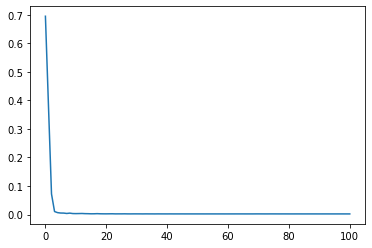

In [74]:
plt.plot(losses)

----

In [ ]:
manual_seed = 232
torch.manual_seed(manual_seed)

n_labels = input_size = next(iter(train_dataloader))['history_mhot'][0].shape[-1]

Uparams = {'hidden_size':[50,100,150,200],
           'lr':[0.005,0.01,0.02],
           'n':[2,4,8,16,32,64]
          }
params = ParameterGrid(Uparams)

evaluator = build_default_evaluator()

for param_set in tqdm(params):
    
    config = {
      "batch": 1,
      "epochs": 100,
      "batch_size": param_set['n'],
      "name":"overfit_batch_altering_batch_size",
      "manual_seed":manual_seed,
        "hidden_size":param_set['hidden_size'],
        "num_layers":1,
        "model":'rnn',
        "lr":param_set["lr"]
    }
    
    wandb.init(project="karpathy-tips-icare", entity="snovaisg",config=config)

    model = RNN(input_size=input_size,
                  hidden_size=param_set['hidden_size'],
                  num_layers=1,
                  n_labels=n_labels,
                  model='rnn')
    
    optimizer = torch.optim.Adam(model.parameters(), lr=param_set['lr'])

    size = param_set['n'] # number of samples to overfit
    np.random.seed(manual_seed)
    overfit_indices = np.random.randint(0,len(dataset),size=(size,))
    small_dataloader = DataLoader(dataset,batch_size=size,collate_fn=ICareCOLLATE(),sampler=SubsetRandomSampler(overfit_indices))
    overfit_batch = next(iter(small_dataloader))
    
    
    n_preds = compute_n_preds(model,overfit_batch)
    batch_loss = compute_batch_loss(model,overfit_batch,reduction='mean')
    batch_metrics = compute_metrics_batch(model,overfit_batch,evaluator,average=True)[0]
    log = dict()
    log.update(batch_metrics)
    log.update({'loss':batch_loss})
    log.update({'epoch':0})
    log.update({'n_preds':n_preds})
    wandb.log(log)

    metrics = None
    for epoch in tqdm(range(1,101)): # 100 epochs
        log = dict()

        # compute loss 
        batch_loss = train_one_batch(model,overfit_batch,optimizer)

        # compute metrics
        batch_metrics = compute_metrics_batch(model,overfit_batch,evaluator,average=True)[0]
        
        n_preds = compute_n_preds(model,overfit_batch)
        log.update({'n_preds':n_preds})
    
        log.update(batch_metrics)
        log.update({'loss':batch_loss})
        log.update({'epoch':epoch})
        
        wandb.log(log)

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▂▄████████████████████████████████████
recall,▁▄██████████████████████████████████████
epoch,100
loss,0.00787
n_preds,14
precision,0.8
recall,0.8


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,0.00953
n_preds,0
precision,0.0
recall,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▂▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,0.01594
n_preds,0
precision,0.0
recall,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▇█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,0.03321
n_preds,0
precision,0.0
recall,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▃▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,0.03278
n_preds,0
precision,0.0
recall,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▇▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▄▅▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,0.03432
n_preds,0
precision,0.0
recall,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁██████▃██▁████████████████████████████
recall,▇▅███▅██▂██▁████████████████████████████
epoch,100
loss,0.00565
n_preds,14
precision,0.8
recall,0.8


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,0.00673
n_preds,0
precision,0.0
recall,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,0.01128
n_preds,0
precision,0.0
recall,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▇▇█▇███
recall,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂
epoch,100
loss,0.02592
n_preds,67
precision,0.14499
recall,0.04601


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,0.03045
n_preds,0
precision,0.0
recall,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,0.03013
n_preds,0
precision,0.0
recall,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▅█▆████████████████████████████████████
recall,▅▇█▁█▅▂▂██▂█████████████████████████████
epoch,100
loss,0.00278
n_preds,10
precision,0.8
recall,0.8


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▅▅▅▇▇▇▇▇▇▇▇▇████████
recall,▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▅▅▅▇▇▇▇▇▇▇▇▇████████
epoch,100
loss,0.00337
n_preds,12
precision,0.625
recall,0.625


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁███████
recall,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂
epoch,100
loss,0.01089
n_preds,1
precision,0.05263
recall,0.02632


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▅▅▅▆▄▆▄▆▃▄▆▆▄▆▇█
recall,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▁▂▁▃▁▂▃▂▂▃▃▃
epoch,100
loss,0.02249
n_preds,110
precision,0.31775
recall,0.15465


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▅▅▆▇▃▆▅▆█▇████▆
recall,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▁▂▂▂▃▃▄▄▄▄▃
epoch,100
loss,0.02023
n_preds,108
precision,0.22939
recall,0.10609


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,0.02867
n_preds,0
precision,0.0
recall,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁██████████████████████████████████████
recall,▁▃██████████████████████████████████████
epoch,100
loss,0.00561
n_preds,10
precision,0.8
recall,0.8


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▃█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,0.00786
n_preds,0
precision,0.0
recall,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,0.0127
n_preds,0
precision,0.0
recall,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃█▃
recall,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁
epoch,100
loss,0.02968
n_preds,17
precision,0.05691
recall,0.00937


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,0.03098
n_preds,0
precision,0.0
recall,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,██▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,██▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,0.03259
n_preds,0
precision,0.0
recall,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▅▇▇▇▇▇▅▅▅▅▅▅▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
recall,▁▇▇▇▇▆▆▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
epoch,100
loss,0.0022
n_preds,11
precision,1.0
recall,1.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅▅▆▇▇▇▇▇▇██
recall,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▅▅▅▆▆▆▆▇▇██
epoch,100
loss,0.00316
n_preds,13
precision,0.75
recall,0.75


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▃▆▃▅▅▅▆▆█
recall,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▁▃▃▃▆▄▆
epoch,100
loss,0.00756
n_preds,12
precision,0.24561
recall,0.19737


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▆▁▇▁▆█▁█▃█▇
recall,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▃▁▂▁▃▃
epoch,100
loss,0.02485
n_preds,157
precision,0.37602
recall,0.16516


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁█▅▃▄
recall,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁
epoch,100
loss,0.02497
n_preds,25
precision,0.08509
recall,0.0187


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,100
loss,0.02982
n_preds,0
precision,0.0
recall,0.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▇▇▇▇▇▅▇▅▇▇▇▇█▇███████████████▅█████████
recall,█▅▂▄▄▄▁▄▂▄▅▅▅█▅███████████████▂███▇█████
epoch,100
loss,0.00033
n_preds,9
precision,1.0
recall,1.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▄▁▁▂▁▁▁▁▁▃▄▅▅▅▆▆▆▇▇▇▇▇▇███████████████
recall,▄▁▂▁▁▁▁▁▁▁▁▃▄▄▅▅▆▆▆▇▇▇▇▇▇███████████████
epoch,100
loss,0.00108
n_preds,15
precision,1.0
recall,1.0


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▃▃▅▅▅▆▆▆▆▆▆▇▇▇██████
recall,▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▄▄▅▆▅▆▆▆▆▇▇▇██████
epoch,100
loss,0.00176
n_preds,36
precision,0.94737
recall,0.94737


  0%|          | 0/100 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
n_preds,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▁▄▄▃▅▅▅▄▅▅▄▅▅▅▆▅▆▇▇█▇██
recall,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▂▂▁▂▂▃▃▃▄▄▄▄▄▄▄▄▅▅▆▆▆▆
epoch,100
loss,0.01285
n_preds,325
precision,0.62589
recall,0.54284


  0%|          | 0/100 [00:00<?, ?it/s]

# Overfit a batch

In [8]:
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from torch import nn
import matplotlib.pyplot as plt
from torchmetrics import functional as f

In [12]:
torch.manual_seed(231)
overfit_batch = next(iter(train_dataloader))

n_labels = input_size = next(iter(train_dataloader))['target_sequences']['sequence'].shape[2]

Uparams = dict(hidden_size=[25,50,100,150,200],
               num_layers=[1,2],
               lr=[0.0001,0.0004,0.004,0.01],
               model=['rnn','lstm','gru'])
params = ParameterGrid(Uparams)

for param_set in tqdm(params):
    
    config = {
      "batch": 1,
      "epochs": 100,
      "batch_size": 64,
      "name":"overfit_batch",
      "manual_seed":231,
        "hidden_size":param_set['hidden_size'],
        "num_layers":param_set['num_layers'],
        "model":param_set['model'],
        "lr":param_set["lr"]
    }
    
    wandb.init(project="karpathy-tips-icare", entity="snovaisg",config=config)

    model = RNN(input_size=input_size,
                  hidden_size=param_set['hidden_size'],
                  num_layers=param_set['num_layers'],
                  n_labels=n_labels,
                  model=param_set['model'])
    criterion = torch.nn.BCEWithLogitsLoss(reduction='none')
    optimizer = torch.optim.Adam(model.parameters(), lr=param_set['lr'])

    overfit_batch = next(iter(train_dataloader))

    losses = list()

    metrics = None
    for epoch in tqdm(range(101)): # 100 epochs
        log = dict()

        # compute loss 
        batch_loss = train_one_batch(model,overfit_batch,criterion,optimizer)
        loss = batch_loss['total_loss'] / (batch_loss['total_sequences'] * n_labels)

        # compute metrics
        batch_metrics = compute_metricsV3_batch(model,overfit_batch)
    
        log.update(batch_metrics)
        log.update({'loss':loss})
        log.update({'epoch':epoch})
        
        wandb.log(log)

        del log

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▂▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▆▆▆▆▇▇▇▇▇█▇▇▇██
loss,████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▂▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇█▇▇▇██
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▂▂▂▂▁▁▁▁▂▂▂▂▂▂▂▃▃▄▄▄▄▅▅▆▆▆▇▇▇▇▇▇█▇▇▇██
epoch,100
f1,0.0
f1@30,0.01783


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████
f1@30,████████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁
loss,█████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████
precision@30,███████████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██████
recall@30,████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▄▄▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁
epoch,100
f1,0.00079
f1@30,0.00782


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▂▂▃▃▃▃▃▃▄▄▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███████
loss,████▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▂▂▃▃▃▃▃▃▄▄▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇███████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▆▆▆▆▆▆▇▇▇▇▇█████████
epoch,100
f1,0.0
f1@30,0.02298


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,█████████████████████████████████▄▄▄▄▄█▁
loss,████▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,█████████████████████████████████▅▅▅▅▅█▁
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁█▅
epoch,100
f1,0.0
f1@30,0.00457


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▂▂▁▁▁▁▁▁▁▂▁▂▂▂▁▂▂▂▂▃▃▄▄▄▄▄▄▄▄▄▅▅▅▆▆████
loss,████▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▂▂▁▁▁▁▁▁▁▂▁▂▂▂▁▂▂▂▂▃▃▄▄▄▅▅▄▄▄▄▅▅▅▆▇████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▅▆▇▇██
epoch,100
f1,0.0
f1@30,0.02617


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,█████████████▇▇▇▇▆▆▆▅▅▅▅▄▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁
loss,████▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,█████████████▇▇▇▇▆▆▆▅▅▅▅▅▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,█████████████▆▆▆▆▆▆▅▅▅▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂
epoch,100
f1,0.0
f1@30,0.02238


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,█▇▆▆▅▆▆▆▅▅▅▅▅▆▅▄▄▆▅▆▄▄▅▅▄▄▃▄▃▂▁▁▂▂▂▂▂▂▂▁
loss,████████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁
precision,████▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,█▇▇▇▅▆▆▆▆▅▅▆▅▆▅▄▄▅▅▅▄▄▄▄▄▃▃▄▃▁▁▁▂▂▁▁▁▁▁▁
recall,████▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▃▂▁▂▁▂▄▄▂▂▂▂▂▄▃▃▄▇▆▆▆▆▆▇▇▆▆▆▇▆▅▇█████▇▇▇
epoch,100
f1,0.0
f1@30,0.01816


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▁▁▁▂▂▂▂▂▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▄▅▅▅▆██▇▇▇▇▇▇▇▇
loss,████████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▁▁▁▂▂▂▂▂▂▁▁▁▁▂▂▂▁▂▂▂▂▂▂▃▄▅▅▅▆██▇▇▇▇▇▇▇▇
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▁▁▂▃▃▃▄▄▃▂▃▂▂▂▃▃▂▃▄▄▄▄▄▄▅▅▄▅▇████▇▇▇▇▇▇
epoch,100
f1,0.0
f1@30,0.01193


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▆▆▆▅▆▅▅▆▆▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█
loss,███████████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▆▆▆▅▆▅▅▅▆▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇█
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▂▂▂▂▂▃▃▅▅▆▇▇▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████
epoch,100
f1,0.0
f1@30,0.0291


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,██▇▇▆▅▆▆▆▆▆▆▆▆▆▅▄▄▄▄▄▄▄▃▂▂▁▁▁▁▂▃▃▃▄▄▄▄▄▄
loss,████████████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▃▃▃▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,██▇▇▆▅▆▆▆▆▆▆▆▆▆▅▄▄▄▄▄▄▄▃▂▂▁▁▁▁▂▃▃▄▄▄▄▄▄▄
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,██▇▇▆▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▂▂▁▁▁▁▂▂▃▃▃▃▃▃▃▃
epoch,100
f1,0.0
f1@30,0.01635


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,███▇▇▇▇▇▆▅▅▅▅▅▅▅▄▅▄▃▃▃▃▃▂▁▁▁▁▂▂▃▃▃▄▄▄▅▆▆
loss,█████████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,███▇▇▇▇▇▆▅▅▅▅▅▅▅▄▅▄▃▃▃▃▃▂▁▁▁▁▂▂▃▃▃▃▄▄▄▅▆
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▃▃▁▁▁▁▂▂▂▃▃▄▅▅▆▇█
epoch,100
f1,0.0
f1@30,0.01465


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇▅▄▃▃▂▂▂▂▂▂▂▂▂▃▃▃▃▃▁▁
loss,██████████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇▅▄▃▃▂▂▂▂▂▂▂▁▂▃▃▃▃▃▁▁
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██▇▅▅▄▃▃▃▃▃▃▂▂▂▃▃▃▃▃▃▁▁
epoch,100
f1,0.0
f1@30,0.01115


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▄▁▃█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▄▅▆▆▆▇▇▇▇▇▇█████████████
loss,██▇▇▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▆▁▃██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅▆▆▆▇▇▇▇▇▇█████████████
recall,▄▁▃█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▄▅▆▆▆▆▇▇▇▇▇█████████████
epoch,100
f1,0.0
f1@30,0.11737


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▄█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▂▁▁▁▁▁▁▁▁▁▂▃▃▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇███████████
loss,██▇▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,██▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▂▁▁▁▁▁▁▁▁▁▂▃▃▃▄▅▅▅▆▆▇▇▇▇▇▇▇▇███████████
recall,▃██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▂▁▁▁▁▁▁▁▁▁▂▃▃▃▄▅▅▆▆▇▇▇▇▇▇▇▇▇███████████
epoch,100
f1,0.0
f1@30,0.12051


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▄▄▅▆▆▇▇▇▇▇▇███████████
loss,███▇▇▇▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▄▄▅▆▆▇▇▇▇▇▇███████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▄▄▅▆▆▇▇▇▇▇▇███████████
epoch,100
f1,0.0
f1@30,0.10919


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▄▅▅▅▆▆▇▇▇▇▇▇▇████████████
loss,███▇▇▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▄▅▅▆▆▆▇▇▇▇▇▇▇████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▂▂▂▂▂▂▂▂▂▂▂▃▄▅▅▅▅▆▆▆▆▇▇▇▇████████████
epoch,100
f1,0.0
f1@30,0.11097


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▂▂▁▁▁▁▁▁▁▂▂▃▄▄▅▅▆▆▇▇▇▇██████████████
loss,███▇▇▆▅▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▂▁▁▁▁▁▁▁▁▂▂▃▃▄▅▅▆▆▇▇▇▇██████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▂▂▁▁▁▁▁▂▂▂▃▄▅▅▆▆▆▇▇▇███████████████
epoch,100
f1,0.0
f1@30,0.10265


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▁▁▁▁▁▂▂▂▄▅▅▅▆▆▆▆▇▇▇▇▇██████████████
loss,███▇▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▁▁▁▁▁▂▂▂▄▅▅▅▆▆▆▆▇▇▇▇▇██████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▂▂▂▂▂▁▁▁▂▂▂▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██████████
epoch,100
f1,0.0
f1@30,0.12548


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▂▂▃▄▆▆▇▇███████████████████████████
loss,█▇▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▂▂▃▄▆▆▇▇███████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▂▂▃▄▆▇▇▇███████████████████████████
epoch,100
f1,0.0
f1@30,0.09988


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▂▂▂▂▄▅▆▇▇█████████████████████████████
loss,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▂▂▂▂▄▅▆▇▇█████████████████████████████
recall,▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▂▂▂▂▅▅▆▇▇█████████████████████████████
epoch,100
f1,0.0
f1@30,0.13901


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▁▃▃▄▆▆▇▇███████████████████████████
loss,██▇▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▁▃▃▄▆▆▇▇███████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▃▃▄▆▇▇▇███████████████████████████
epoch,100
f1,0.0
f1@30,0.11734


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▂▃▃▄▅▇▇█████████████████████████████
loss,██▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▂▃▃▄▅▇▇█████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▂▃▃▄▅▇▇█████████████████████████████
epoch,100
f1,0.0
f1@30,0.12627


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▂▅▆▆▆▇▇▇███████████████████████████
loss,██▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▂▅▆▇▇▇▇████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▂▄▅▆▆▆▇▇███████████████████████████
epoch,100
f1,0.0
f1@30,0.1483


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▂▂▂▃▄▄▆▇▇█████████████████████████████
loss,██▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▂▂▂▃▄▄▆▇▇█████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▂▂▂▃▄▄▆▇▇█████████████████████████████
epoch,100
f1,0.0
f1@30,0.12299


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▃▃▃▄▄▄▄▄▅▅▅▅▅▆▇▇▇▇▇▇██▇▇▇▇▇▇▇▆▆▆▅▅▄▄▄▂▁▁
loss,██████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▃▄▄▄▄▄▄▄▅▅▅▅▅▆▇▇▇▇▇▇██▇▇▇▇▇▇▇▆▆▆▅▅▄▄▄▂▁▁
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▃▃▄▄▄▄▄▄▄▄▅▅▆▆▆▇▇█▇██▇▇█▇▇▇▇▆▆▅▄▄▄▄▃▂▁▁
epoch,100
f1,0.0
f1@30,0.00946


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,███▇▇▇▇▇▇▇▆▅▅▇▆▆▆▆▅▄▄▄▄▃▃▃▃▂▁▂▂▁▁▁▁▁▁▁▁▁
loss,█████████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,██▇▇▇▇▇▇▇▇▆▅▅▇▆▆▆▆▅▄▄▄▄▃▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▇▇██▇▇▇▇██▇▇▇█▇▇▆▆▅▄▄▄▃▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁
epoch,100
f1,0.0
f1@30,0.01584


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▂▂▂▃▃▃▃▃▄▄▄▄▆▆▆▇▇▇▆▅▅▂▃▃▃▂▃▅▃▃█▆▆█▇▇▄▅▅
loss,████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▂▂▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▂▂▂▃▃▃▃▃▅▅▅▅▆▆▆▇▇▇▆▅▅▂▃▃▃▂▃▅▃▃█▆▆█▇▇▅▅▅
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▂▂▂▃▃▃▃▃▄▄▄▄▇▇▇███▇▆▆▄▅▅▅▄▅▆▅▄▇▅▅█▅▅▃▄▄
epoch,100
f1,0.0
f1@30,0.01105


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▃▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇██
loss,██████▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▃▅▅▆▆▆▆▆▆▆▆▇▇▆▇▆▇▇▇▇▇██
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▅▅▅▆▅▅▆▆▆▅▅▄▄▄▄▁▁▂▆▆██▆▆▆▅▄▄▅▃▃▃▄▄▅▅▅▆██
epoch,100
f1,0.0
f1@30,0.01962


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▄▄▄▃▂▁▁▂▃▃▂▂▂▂▃▂▁▂▂▃▃▄▅▄▆▅▅▆▆████▇██▇▇▇▇
loss,████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▄▄▄▃▂▁▁▂▃▃▂▂▂▂▃▂▁▁▂▃▃▄▅▄▆▅▅▆▆████▇██▇▇▇▆
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▃▃▃▂▁▁▁▁▃▃▂▂▂▃▃▂▂▂▃▄▄▅▆▆▇▆▆▆▆▇███████▇▇█
epoch,100
f1,0.0
f1@30,0.02511


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▃▃▃▂▁▁▂▂▂▃▃▃
loss,██████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▇▇▇▇█▇█▇█▇▇▇▇▇█▇▇▇▇▇▆▆▅▅▅▅▄▄▃▃▃▂▁▁▂▂▂▃▃▃
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,███▇█▇▇▇▇▇▆▆▆▇▇▇▇▆▆▆▅▅▄▄▄▄▄▄▃▃▃▂▂▁▁▁▂▂▂▂
epoch,100
f1,0.0
f1@30,0.02082


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▅▆▇▇▇▇▇▇▇▇▇█████████
loss,█████████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▅▆▇▇▇▇▇▇▇▇▇█████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▅▆▆▇▇▇▇▇▇▇▇█████████
epoch,100
f1,0.0
f1@30,0.03584


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▂▃▄▄▅▅▄▄▄▄▄▃▂▁▂▄▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆█
loss,███████▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▂▃▄▄▅▅▄▄▄▄▄▃▂▁▂▄▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆█
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▂▃▄▅▅▅▄▃▄▄▃▃▂▁▂▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆█
epoch,100
f1,0.0
f1@30,0.03428


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▅▅▄▃▃▃▃▂▂▂▂▂▁▁▇█
loss,█████████████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▂▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▇▆▆▅▅▄▃▃▃▃▂▂▂▁▂▁▁▇█
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▆▆▆▆▆▅▅▅▆▆▆▆▆▆▆▆▅▆▅▅▅▆▅▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▇█
epoch,100
f1,0.0
f1@30,0.02686


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄████
loss,████████████▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▂▂▂▃▃▄▄▃▃▃▃▃▃▃▃▃▃▄████
epoch,100
f1,0.0
f1@30,0.03258


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▄▄▄▄▄▄▄▅▅▅▅█
loss,██████████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▄▄▄▄▄▄▄▄▅▅▅▅█
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▃▃▃▃▃▃▃▃▂▃▃▃▃▂▂▁▂▁▂▂▂▂▂▂▂▂▃▄▄▄▄▄▃▄▄▅▅▅▅█
epoch,100
f1,0.0
f1@30,0.02595


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▃▂▂▂▃▃▃▃▃▄▄▄▅▆▇██▇▄▃▃▄▅▃▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂
loss,█████████▇▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▃▂▂▂▃▃▃▃▃▄▄▄▅▇▇██▇▄▃▃▄▅▃▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▁▁▁▁▁▂▂▂▂▃▃▄▆▇███▄▃▃▃▄▃▂▂▂▂▂▄▄▃▃▃▃▃▃▃▃▃
epoch,100
f1,0.0
f1@30,0.0194


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▁▂▃▅▆▇▇▇███████████████████████████
loss,██▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▁▂▃▅▆▇▇▇███████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▂▃▅▆▆▇▇▇██████████████████████████
epoch,100
f1,0.0
f1@30,0.15236


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▂▃▄▄▅▆▇▇▇██████████████████████████
loss,██▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▂▃▄▄▅▆▇▇▇██████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▂▃▃▄▄▅▆▇▇▇█████████████████████████
epoch,100
f1,0.0
f1@30,0.14608


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▂▂▁▁▁▂▃▄▅▆▇▇███████████████████████████
loss,███▇▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▂▂▁▁▁▂▃▄▅▆▇▇███████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▂▂▃▄▆▇▇███████████████████████████
epoch,100
f1,0.0
f1@30,0.14806


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▂▂▂▁▂▃▄▅▆▆▆▇▇▇█████████████████████████
loss,██▇▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▂▂▂▂▂▃▄▅▆▆▇▇▇▇█████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▂▂▁▁▂▃▄▅▅▆▆▆▇▇█████████████████████████
epoch,100
f1,0.0
f1@30,0.14317


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▁▂▂▄▆▆▇▇▇▇█████████████████████████
loss,██▇▇▆▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▂▂▂▄▆▆▇▇▇▇█████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▂▂▄▆▆▇▇▇▇█████████████████████████
epoch,100
f1,0.0
f1@30,0.14261


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▂▁▁▂▂▂▂▃▄▅▅▆▇▇▇████████████████████████
loss,██▇▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▂▁▁▂▂▂▂▃▄▅▅▆▇▇▇████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▁▁▁▂▂▂▂▃▄▄▅▆▆▇▇▇███████████████████████
epoch,100
f1,0.0
f1@30,0.11209


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▄▆▇█████████████████████████████████
loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▄▆▇█████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▄▆▇▇████████████████████████████████
epoch,100
f1,0.0
f1@30,0.11469


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▃▅▇█████████████████████████████████
loss,█▆▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▃▅▇█████████████████████████████████
recall,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▃▅▇█████████████████████████████████
epoch,100
f1,0.0
f1@30,0.10216


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▃▅▇▇▇███████████████████████████████
loss,█▇▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▃▅▇▇▇███████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▃▄▆▇▇███████████████████████████████
epoch,100
f1,0.0
f1@30,0.1153


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▃▅▇█████████████████████████████████
loss,██▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▃▅▇█████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▃▅▆█████████████████████████████████
epoch,100
f1,0.0
f1@30,0.11145


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▃▄▆▇▇███████████████████████████████
loss,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▃▄▆▇▇███████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▂▄▆▇▇▇▇▇▇███████████████████████████
epoch,100
f1,0.0
f1@30,0.10328


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▃▅▇█████████████████████████████████
loss,█▇▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▃▅▇█████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▃▅▇█████████████████████████████████
epoch,100
f1,0.0
f1@30,0.11567


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,█████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁
loss,█████████████▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▄▄▃▃▃▂▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,█████▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁▁▁▁▁▁▁
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,████████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁
epoch,100
f1,0.0
f1@30,0.00711


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▂▂▂▃▅▆▆▇▇▆▆▅▅▅▃▄▂▂▂▄▅▆▆▆▆▆▆▆▇▇█████▇▆▆▆
loss,██████████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▂▂▂▃▅▆▆▇▇▆▆▅▅▄▃▃▂▂▂▄▅▆▆▆▆▆▆▆▇▇█████▇▆▆▆
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▂▃▃▄▅▆▆▆▆▅▄▄▆▆▃▇▆▆▆█▇▅▅▅▅▅▅▅███████▆▅▅▅
epoch,100
f1,0.0
f1@30,0.00858


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▄▆▇▇████
loss,███████████▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▄▄▃▃▂▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▄▆▇▇████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▄▆▇▇████
epoch,100
f1,0.0
f1@30,0.01672


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,████▇▇▇▇▇▇▇▇▆▆▇▆▅▅▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▂▃▄▄▅▅
loss,████████████████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▅▅▄▄▃▃▂▂▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,████▇▇▇▇▇▇▇▇▆▆▇▆▅▅▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▂▃▄▄▅▅
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,██▇█▇██████▇▆▆▇▇▆▅▄▄▃▃▃▃▂▂▂▁▁▂▁▁▁▁▄▄▅▆▇█
epoch,100
f1,0.0
f1@30,0.01485


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▅▅▅▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▁▁▂▁▁▂▂▃▃▃▄▄▆▇█
loss,███████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▄▄▄▄▅▄▅▅▄▃▃▃▃▃▃▃▂▃▃▂▂▂▂▁▂▁▁▂▁▁▂▂▃▃▃▄▄▆▇█
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▄▅▅▅▄▄▄▃▃▁▁▂▁▁▃▃▄▄▄▄▄▆▇█
epoch,100
f1,0.0
f1@30,0.02051


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,███▇▇▇▇▆▆▆▆▅▄▃▃▃▃▂▂▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂
loss,█████████████▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,███▇▇▇▇▆▆▆▆▅▄▃▃▃▃▂▂▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,███▇▇▇▇▇▆▆▆▅▄▃▃▃▃▃▂▂▁▁▁▁▁▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
epoch,100
f1,0.0
f1@30,0.00769


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▄▅▅▅▅▅▅▆▆▇▇██
loss,██████▇▇▇▇▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▆▇▇██
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▂▂▂▂▂▂▂▂▂▃▂▃▂▃▃▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▇▇██
epoch,100
f1,0.0
f1@30,0.07176


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▄▄▄▅▅▅▆▇▇▇██
loss,████▇▇▇▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▄▄▄▅▅▅▆▇▇▇██
recall,▁▁▁▁▁▁▅█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▄▄▄▅▅▅▆▇▇▇██
epoch,100
f1,0.0
f1@30,0.08554


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▃▃▄▅▅▆▆▇▇██
loss,██████████▇▇▇▇▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▂▁▁▁▂▃▃▄▅▅▆▆▇▇██
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▄▄▄▅▅▆▇██
epoch,100
f1,0.0
f1@30,0.08413


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▅▅▅▅▅▆▆▆▇███
loss,█████████▇▇▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▅▅▅▅▆▆▆▇███
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▅▅▅▆▆▆▆▆▇▇▇█
epoch,100
f1,0.0
f1@30,0.07568


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▄▄▄▄▅▆▆▇▇████
loss,█████████▇▇▇▇▇▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▄▅▆▆▇▇████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▄▄▄▄▅▆▆▇▇█▇██
epoch,100
f1,0.0
f1@30,0.09484


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▄▄▄▄▅▅▆▆▆▇▇▇▇██
loss,███████▇▇▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▄▄▄▄▅▅▆▆▆▇▇▇▇██
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▄▄▄▄▅▆▆▆▇▇▇▇███
epoch,100
f1,0.0
f1@30,0.10751


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▂▄▅▆▇████████████████████████████████
loss,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▂▄▅▆▇████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▂▄▅▆▇████████████████████████████████
epoch,100
f1,0.0
f1@30,0.14282


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▃▄▆▇████████████████████████████████
loss,█▇▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▃▄▆▇████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▃▄▆▇▇███████████████████████████████
epoch,100
f1,0.0
f1@30,0.12615


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▂▂▂▃▄▆▇████████████████████████████████
loss,██▇▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▂▂▂▃▄▆▇████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▂▃▃▃▄▆▇████████████████████████████████
epoch,100
f1,0.0
f1@30,0.12089


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▁▁▁▂▄▅▆▇███████████████████████████████
loss,██▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▁▁▁▂▄▅▆▇███████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▁▁▁▂▄▅▆▇███████████████████████████████
epoch,100
f1,0.0
f1@30,0.12601


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▂▂▂▄▆▆▇▇██████████████████████████████
loss,██▇▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▂▂▂▄▆▆▇▇██████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▂▁▂▄▆▆▇▇██████████████████████████████
epoch,100
f1,0.0
f1@30,0.12348


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▃▄▆▇████████████████████████████████
loss,██▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▃▄▆▇████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▂▅▆▇████████████████████████████████
epoch,100
f1,0.0
f1@30,0.12108


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▄▆▇███████████████████████████████████
loss,█▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▅▆▇███████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▄▆▇██████████▇██▇█████████████████████
epoch,100
f1,0.0
f1@30,0.15317


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▁▄▆▇███████████████████████████████████
loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▁▄▆▇███████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▃▁▃▆▇██████████▇▇▇██████████████████████
epoch,100
f1,0.0
f1@30,0.10915


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▂▅▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█████████████████████
loss,█▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▂▅▇▇▇████▇▇▇▇▇▇▇▇█████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▂▂▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██████████████████
epoch,100
f1,0.0
f1@30,0.12637


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▂▅▇███████████████████████████████████
loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▂▅▇███████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▂▅▇██████████▇▇███████████████████████
epoch,100
f1,0.0
f1@30,0.13397


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▄▇█
f1@30,▁▁▁▄▆▇▇▇▇▇▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
loss,█▇▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▄▄▄▄▄▄▄▄▇█
precision@30,▁▁▁▄▆▇▇▇▇▇▇▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▄▄▃▄▇█
recall@30,▁▁▁▄▆▆▇▇▇▇▇▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,100
f1,0.01029
f1@30,0.13529


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▂▅▇█████████▇▇▇▇██████████████████████
loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▂▅▇█████████▇▇▇▇██████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▂▅▇█████████▇▇▇███████████████████████
epoch,100
f1,0.0
f1@30,0.11043


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▇▇█▇▇▆▇▇█▆▆▅▅▃▂▂▂▃▃▃▂▂▁▁▁▂▂▂▄▄▄▅▄▄▄▄▄▃▃▃
loss,████████████▇▇▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▇▇█▇▇▆▇▇█▆▆▅▅▂▁▁▂▃▃▃▂▂▁▁▁▂▂▂▄▄▄▅▄▄▄▃▃▃▃▃
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▇█▇▆▆▆█▇█▇▇▆▆▄▄▃▄▄▃▃▂▂▁▂▂▂▂▂▄▄▄▅▅▅▅▄▄▄▄▄
epoch,100
f1,0.0
f1@30,0.01618


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▂▂▂▂▃▃▃▄▃▂▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆█
loss,█████████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▂▂▂▂▃▃▄▄▃▂▁▁▁▁▁▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▆▆▆█
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▃▃▃▃▃▃▃▃▃▂▂▁▁▁▁▁▂▃▃▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▆▆▇█
epoch,100
f1,0.0
f1@30,0.07181


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▃▁▂▃▄▄▄▄▄▅▆███
loss,██████████████████▇▇▇▇▇▇▇▇▇▆▆▆▅▅▄▄▃▃▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▃▁▂▃▄▄▄▄▄▅▆███
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▅▅▅▅▄▃▁▂▄▄▄▄▄▅▅▇███
epoch,100
f1,0.0
f1@30,0.041


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,██▇▇▇▆▆▆▆▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
loss,█████████████████▇▇▇▇▇▇▇▇▆▆▆▆▅▅▄▄▃▃▃▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,██▇▇▇▆▆▆▆▅▅▄▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,███▇▇▇▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▁▁▁
epoch,100
f1,0.0
f1@30,0.0128


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▂▃▄▄▅▅▅▆▇▇▇▆▇█▇▇▇▇▆▆▆▆▅▅▄▅▅▇▇▇██▇▇████
loss,█████████████▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▄▄▃▃▂▂▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▂▃▄▄▅▅▅▆▇▇▇▆▇█▇▇▇▇▇▆▇▆▆▅▅▅▅▇▇▇██▇▇████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▃▃▄▅▅▅▅▅▇▇▇▇▆▆█▆▆▅▅▃▃▃▂▂▁▁▂▂▄▅▅▄▅▄▄▅▅▅▅
epoch,100
f1,0.0
f1@30,0.03494


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▂▂▂▂▂▁▁▁▁▁▁▁▂▂▂▄▆▇▇▆▆▆▅▅▅▅▆▇▇██▇█████
loss,██████████████▇▇▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▃▃▃▂▂▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▂▂▂▂▂▁▁▁▁▁▁▁▂▂▂▄▆▇▇▇▆▆▆▅▅▅▆▇▇██▇█████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▂▂▃▃▂▂▂▁▁▁▁▁▁▁▁▂▂▃▄▅▅▅▅▅▅▅▅▅▆▆▆▇▇▇█████
epoch,100
f1,0.0
f1@30,0.01604


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▃▃▃▃▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇███
loss,█████▇▇▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▂▃▃▃▃▃▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇███
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▃▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇███
epoch,100
f1,0.0
f1@30,0.0906


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇██
loss,████▇▇▆▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇▇██
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇██
epoch,100
f1,0.0
f1@30,0.08401


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇▇▇▇▇███████
loss,████████▇▇▇▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇▇▇▇██████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▂▃▃▃▃▄▄▄▅▅▆▆▆▇▇▇▇▇▇██████
epoch,100
f1,0.0
f1@30,0.14671


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇███
loss,████████▇▇▆▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇███
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▃▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇███
epoch,100
f1,0.0
f1@30,0.08546


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▄▅▅▆▆▆▆▇▇▇▇████
loss,████████▇▇▇▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▄▅▅▆▆▆▆▇▇▇▇████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▄▅▅▅▆▆▆▇▇▇▇▇▇██
epoch,100
f1,0.0
f1@30,0.10825


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇▇█████████
loss,█████▇▇▇▆▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇▇█████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▂▂▂▂▂▂▂▁▁▂▂▂▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇█████████
epoch,100
f1,0.0
f1@30,0.14389


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▂▂▃▅▆▇▇████████████████████████████████
loss,█▇▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▂▂▃▅▆▇▇████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▂▃▅▆▇▇▇███████████████████████████████
epoch,100
f1,0.0
f1@30,0.10941


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▂▃▆▇██████████████████████████████████
loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▂▃▆▇██████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▂▃▆▇██████████████████████████████████
epoch,100
f1,0.0
f1@30,0.13699


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▂▂▅▆▇█████████████████████████████████
loss,██▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▂▂▅▆▇█████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▂▂▅▆▇▇████████████████████████████████
epoch,100
f1,0.0
f1@30,0.12692


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▄▅▇████████▇▇▇█▇████████████████████
loss,██▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▄▅▇████████▇▇▇█▇████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▄▅▇████████▇█▇█▇██▇█████████████████
epoch,100
f1,0.0
f1@30,0.10599


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▂▄▆▇█████████████████████████████████
loss,██▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▂▄▆▇█████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▂▄▆▇▇████████████████████████████████
epoch,100
f1,0.0
f1@30,0.11244


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▂▄▆▇▇█████████████████████████████████
loss,█▇▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▂▄▆▇▇█████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▂▃▆▇▇██████████▇▇▇████████████████████
epoch,100
f1,0.0
f1@30,0.12067


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▆▇█████▇▇▇▇▇▇█████████████████████████
loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▆▇█████▇▇▇▇▇▇█████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▆▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█████████████████████
epoch,100
f1,0.0
f1@30,0.12422


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▂▇██████▇▇█████████████████████████████
loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▂▇██████▇▇█████████████████████████████
recall,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▂▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇██████████████████
epoch,100
f1,0.0
f1@30,0.17989


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▂▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
loss,█▇▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▂▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▂▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
epoch,100
f1,0.0
f1@30,0.12411


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▄▅▆▆▆▇█▁▁▁▇▃▃▄▆▆▇▇▆▅▆▆▆▇
f1@30,▁▂▅▆▇▇▇▇▇▆▆▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇█████████████
loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▄▄▅▆▆▇▇█▁▁▁▇▅▄▆▇▇▇▇▆▆▆▇▆▇
precision@30,▁▂▅▆▇▇▇▇▇▆▆▇▇▇▇▇▇▇▇▇█▇▇█▇▇▇█████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▄▄▅▆▆▆▇█▁▁▁▆▃▃▃▆▆▆▆▆▄▆▆▆▇
recall@30,▁▂▄▆▇▇▇▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
epoch,100
f1,0.0917
f1@30,0.16309


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▄▅▅▅▅▅▅▆▆▇▇▇█
f1@30,▁▁▅▆▇▆▆▆▇▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████
loss,█▇▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▅▅▅▅▅▆▆▆▆▇▇██
precision@30,▁▁▅▆▇▆▆▆▇▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▄▅▅▅▅▅▅▆▆▇▇▇█
recall@30,▁▁▅▆▆▆▆▆▇▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████
epoch,100
f1,0.23056
f1@30,0.15554


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▅▆▇▇▇▇▆███████▆███
f1@30,▁▁▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇▇▇▇▇▇▇▆▇▇▇▇█▇█▆▇▇█
precision@30,▁▁▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▅▅▆▆▆▆▆▇█████▇▆███
recall@30,▁▁▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
epoch,100
f1,0.09444
f1@30,0.14488


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▆█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▅▅▅▆▇████
loss,███████████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▆█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▅▅▅▆▇█▇██
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▆█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▂▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▂▂▂▁▂▂▂▂▂▂▂▃▅▆▆▇▇████
epoch,100
f1,0.0
f1@30,0.05304


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▃▃▃▄▄▄▃▃▃▅▆▆▆▆▅▅▇▇▇▇▇▇████████████████
loss,█████████▇▇▇▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▃▃▃▄▄▄▃▃▃▅▆▆▆▆▅▅▇▇▇▇▇▇████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▃▃▂▃▃▃▂▂▂▄▅▅▆▆▆▅▇▇▇▇▇▇████▇▇▇▇▇█▇██▇██
epoch,100
f1,0.0
f1@30,0.02451


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▇▇▇▇▇▇██████████████▄▃▃▂▃▁▂▂▂▁▂▁▁▁▂▂▂▂▂▁
loss,████████████████▇▇▇▇▇▇▇▇▇▆▆▆▆▅▅▄▄▃▃▃▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▇▇▇▇▇▇██████████████▄▃▃▂▃▁▂▂▂▁▂▁▁▁▂▂▂▂▂▁
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,████████████████████▅▄▃▂▃▂▂▂▂▁▁▁▁▁▂▂▂▂▂▁
epoch,100
f1,0.0
f1@30,0.01191


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▃▃▃▃▃▃▄▄▄▄▄▃▂▂▁▁▁▂▃▃▄▄▄▅▆▆▆▆▆▆▇▇▇▇▆▇████
loss,████████████████▇▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▃▃▃▃▃▃▄▄▄▄▄▃▂▂▁▁▁▂▃▃▄▄▄▅▆▆▆▆▆▆▇▇▇▇▆▇████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▃▃▄▃▃▃▃▃▄▄▄▃▁▁▂▁▂▂▃▃▄▄▃▅▆▆▇▇▇▆▆▇▇▇▆▇▇▇▇█
epoch,100
f1,0.0
f1@30,0.02214


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,█████▇▇▇▇▆▆▅▅▆▅▅▅▅▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂
loss,████████████████▇▇▇▇▇▇▇▇▇▆▆▆▅▅▄▄▃▃▂▂▂▂▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,█████▇▇▇▇▆▆▆▅▆▅▅▅▅▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,████▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▂▂▂▂▂▂▁▁▁▁▂▂▂▁▂▂▂▂▂
epoch,100
f1,0.0
f1@30,0.01178


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▆▆▆▆▆▆▆▆▆▆▆▆▇▇█████▆▅▅▄▄▄▄▃▁▁▂▃▄▄▄▄▅▅▅██
loss,█████████████▇▇▇▇▇▇▇▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▆▆▆▆▆▆▆▆▆▆▆▆▆▇█████▆▅▅▄▄▄▄▃▁▁▂▃▄▄▄▅▅▅▅██
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▇▇▇▇▇▇▇▇▇▆▆▇▇██████▇▅▅▄▃▃▃▂▁▁▂▂▃▃▃▃▃▃▃▅▅
epoch,100
f1,0.0
f1@30,0.03583


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇████████
loss,████▇▇▆▅▅▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇█████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▄▄▄▅▆▆▆▆▆▇▇▇▇▇████████
epoch,100
f1,0.0
f1@30,0.12794


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▂▂▂▂▁▁▁▁▁▁▂▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
loss,███▇▆▆▅▄▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▂▂▂▂▁▁▁▁▁▁▂▂▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▂▂▁▁▁▁▁▁▁▁▂▂▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
epoch,100
f1,0.0
f1@30,0.1029


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇█████████
loss,███████▇▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇█████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▄▅▅▆▆▆▆▇▇▇▇▇▇▇█████████
epoch,100
f1,0.0
f1@30,0.13813


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▁▁▁▁▁▂▁▁▁▁▂▂▂▂▃▃▄▅▅▆▆▇▇▇▇▇█████████████
loss,██████▇▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▂▁▁▁▁▂▁▁▁▁▂▂▂▂▃▃▄▅▅▆▆▇▇▇▇▇█████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▂▁▁▁▁▂▁▁▁▁▂▂▂▂▃▃▄▅▅▆▆▆▇▇▇▇█████████████
epoch,100
f1,0.0
f1@30,0.14207


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇████
loss,██████▇▇▇▇▆▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▄▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇████
epoch,100
f1,0.0
f1@30,0.08671


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▅▆▆▇▇▇▇███████████████
loss,█████▇▇▆▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▅▆▆▇▇▇▇▇▇█████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▄▅▅▆▆▇▇▇▇███████████████
epoch,100
f1,0.0
f1@30,0.13593


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▃▅▇███████████████████████████████████
loss,█▆▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▃▅▇███████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▃▅▇███████████████████████████████████
epoch,100
f1,0.0
f1@30,0.11513


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▂▃▅████████████████████████████████████
loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▂▃▅████████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▂▃▅▇███████████████████████████████████
epoch,100
f1,0.0
f1@30,0.14297


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▁▃▆▇██████████▇███████████████████████
loss,██▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▁▃▆▇██████████▇███████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▃▅▆▇▇▇▇▇▇████▇▇▇▇▇▇██████████████████
epoch,100
f1,0.0
f1@30,0.11551


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▂▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
loss,█▇▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▂▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████▇█
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▁▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███████████▇▇▇█▇
epoch,100
f1,0.0
f1@30,0.13716


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▂▁▂▄▇▇██████████████████████████████████
loss,█▇▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▂▁▂▄▇▇██████████████████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▁▂▃▆▇▇████████▇▇███████████████████████
epoch,100
f1,0.0
f1@30,0.1229


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▂▆▇███████▇▇▇▇▇███████████████████████
loss,█▇▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▂▆▇██████▇▇▇▇▇▇███████████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▂▆▇▇████████▇▇▇███████████████████████
epoch,100
f1,0.0
f1@30,0.13556


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇███████████████████
loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇███████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▂▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███████████████████
epoch,100
f1,0.0
f1@30,0.12154


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▃█████▇▇▇▇▇▇███████████████████████████
loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▃█████▇▇▇▇▇▇███████████████████████████
recall,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▃▇█████▇▇▇████▇▇███████████████████████
epoch,100
f1,0.0
f1@30,0.15723


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▃▁
f1@30,▁▁▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▅▅▁
precision@30,▁▁▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▃▃▁
recall@30,▁▁▆▇▇▇▇▇▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████
epoch,100
f1,0.0
f1@30,0.16173


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
f1@30,▁▁▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
loss,█▅▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision@30,▁▁▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
recall@30,▁▁▄▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
epoch,100
f1,0.0
f1@30,0.10695


  0%|          | 0/101 [00:00<?, ?it/s]

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▄▅▆▆▆▇▇▇▇█
f1@30,▁▁▅▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████
loss,█▆▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
precision,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▃▃▄▄▄▄▅▅▅▆▆▇▇▇▇▇██
precision@30,▁▁▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████████
recall,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▄▄▄▅▆▆▆▆▇▇▇█
recall@30,▁▁▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████
epoch,100
f1,0.35106
f1@30,0.14873


  0%|          | 0/101 [00:00<?, ?it/s]

# Saving models

In [39]:
#param_set = {
#          'hidden_size':100,
#          'num_layers':1,
##          'lr':0.01,
#          'model':'rnn'
#         }
for idx,param_set in tqdm(enumerate(params)):
    config = {**param_set, 
              **meta_parameters}
    
    wandb.init(
        project="icare", 
        config=config
    )
    
    model = RNN(input_size=input_size,
              hidden_size=config['hidden_size'],
              num_layers=config['num_layers'],
              n_labels=n_labels,
              model=config['model'])
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
    
    loss = compute_loss(model,train_dataloader)
    wandb.log({'epoch':0,'loss':loss})
    
    print('Training each epoch')
    for epoch in tqdm(range(1,config['epochs']+1)):
        
        loss = train_one_epochV2(model,train_dataloader,epoch,criterion,optimizer);
        wandb.log({'epoch':epoch,'loss':loss})
        
        
    
    train_metrics = compute_metricsV3(model,train_dataloader)
    train_metrics = {f'train_{k}':train_metrics[k] for k in train_metrics}
    
    val_metrics = compute_metricsV3(model,val_dataloader)
    val_metrics = {f'val_{k}':val_metrics[k] for k in val_metrics}    

    log = dict()

    log.update(train_metrics)
    log.update(val_metrics)

    wandb.log(log)
    
    model_name = str(param_set)

    hypp_save_path = os.path.join(model_folder, model_name+'_hyper_parameters.json')

    with open(hypp_save_path, "w") as file:
        json.dump(params, file)

    print('Hyperparameters saved!')
    
    weights_save_path = os.path.join(model_folder,model_name+"_weights")

    torch.save(model.state_dict(), 
               weights_save_path
              )
    print('Model saved!')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Starting to train each batch


0it [00:00, ?it/s]

NameError: name 'compute_metricsV3' is not defined